In [1]:
import numpy as np
from main_funcs import *
from free_lie_algebra import * 
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

plt.style.use('seaborn-darkgrid')

e:\File_VSCode\M3R\m3r_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Besty\AppData\Local\Temp\ipykernel_56188\414910782.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [5]:
# construct a random function
def random_sine_generator(seed=1531):
    np.random.seed(seed)
    freq = np.random.normal(np.random.uniform(10, 30), np.random.uniform(5, 10), size=np.random.randint(5, 20))
    def func(t):
        if isinstance(t, float):
            return sum(np.sin(freq*t))
        else:
            return np.sum(np.sin(np.outer(freq, t)), axis=0)
    return func

def point_coef(x, t_grid, N, eps=0.1):
    n = len(t_grid)
    x_recon = np.zeros(n)
    for i in range(n):
        hpoly = Hermite(t_grid[i], eps)
        x_recon[i] = hpoly.ploy2path(x, N, t_grid[i])
    return x_recon

def point_sig(x, t_grid, N, eps=0.1, more_truc=0):
    n = len(t_grid)
    x_recon = np.zeros(n)
    for i in range(n):
        hpoly = Hermite(t_grid[i], eps, start_poiint=-1)
        if callable(x):
            path_time = np.c_[t_grid, x(t_grid)*hpoly.weight(t_grid)]
        else:
            path_time = np.c_[t_grid, x*hpoly.weight(t_grid)]
        sig = signature_of_path_iisignature(path_time, N+2+more_truc)
        x_recon[i] = hpoly.sig2path(sig, N, t_grid)[i]
    return x_recon

### Signed area

In [33]:
t_arr = np.linspace(0, 2*np.pi, 100)
x_arr = np.sin(t_arr)+3

C:\Users\Besty\AppData\Local\Temp\ipykernel_18988\629364932.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


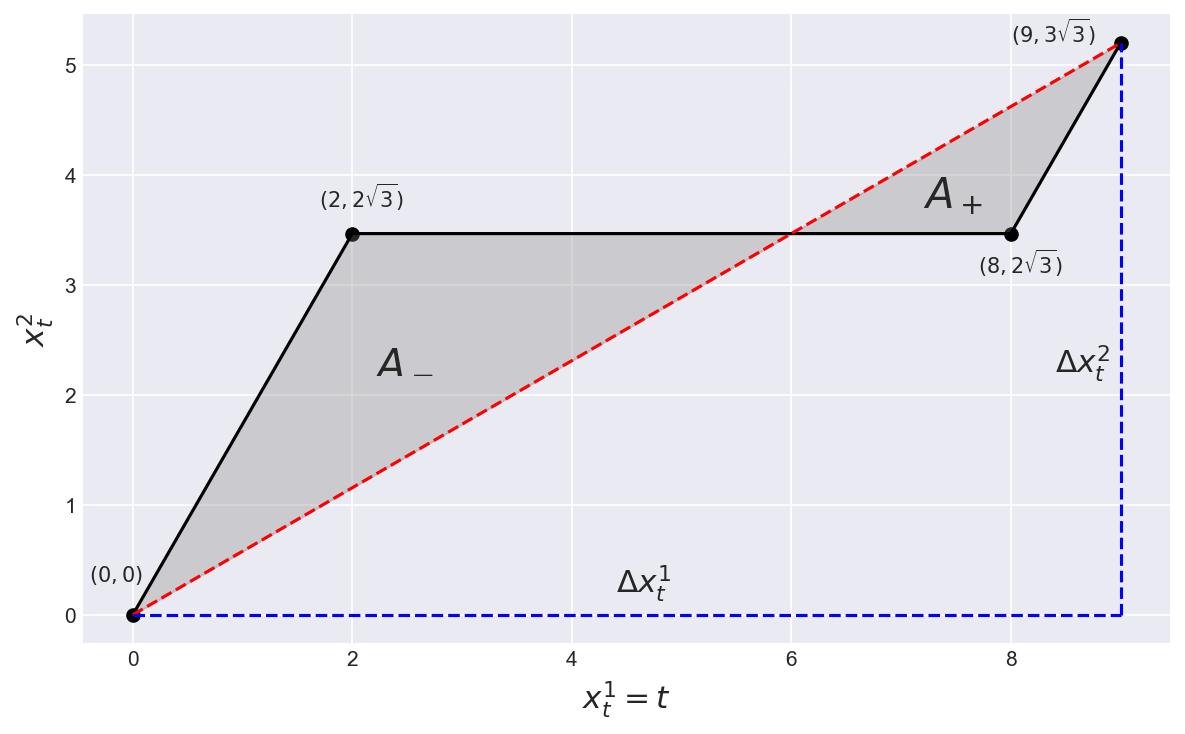

In [125]:
plt.figure(figsize=(8, 5), dpi=150)

plt.plot((0, 2, 8, 9), (0, 2*3**0.5, 2*3**0.5, 3*3**0.5), c='black')
plt.plot((0, 9), (0, 3*3**0.5), color='red', linestyle='dashed')
plt.scatter((0, 2, 8, 9), (0, 2*3**0.5, 2*3**0.5, 3*3**0.5), c='black')
plt.fill_between((0, 2, 8, 9), (0, 2*3**0.5, 2*3**0.5, 3*3**0.5), (0, 2/3**0.5, 2*3**0.5+2/3**0.5, 3*3**0.5),
                 facecolor="orange", # The fill color
                 color='grey',       # The outline color
                 alpha=0.3)
plt.hlines(0, 0, 9, colors='b', linestyles='dashed')
plt.vlines(9, 0, 3*3**0.5, colors='b', linestyles='dashed')
plt.annotate(r'$(0, 0)$', (-0.4, 0.3))
plt.annotate(r'$(2, 2\sqrt{3})$', (1.7, 3.7))
plt.annotate(r'$(8, 2\sqrt{3})$', (7.7, 3.1))
plt.annotate(r'$(9, 3\sqrt{3})$', (8, 5.2))
plt.annotate(r'$\Delta x_t^1$', (4.4, 0.2), fontsize=15)
plt.annotate(r'$\Delta x_t^2$', (8.4, 2.2), fontsize=15)
plt.annotate(r'$A_-$', (2.2, 2.2), fontsize=20)
plt.annotate(r'$A_+$', (7.2, 3.7), fontsize=20)
plt.ylabel(r'$x^2_t$', fontsize=15)
plt.xlabel(r'$x^1_t=t$', fontsize=15)
plt.tight_layout()
# plt.savefig('signed_area.pdf')

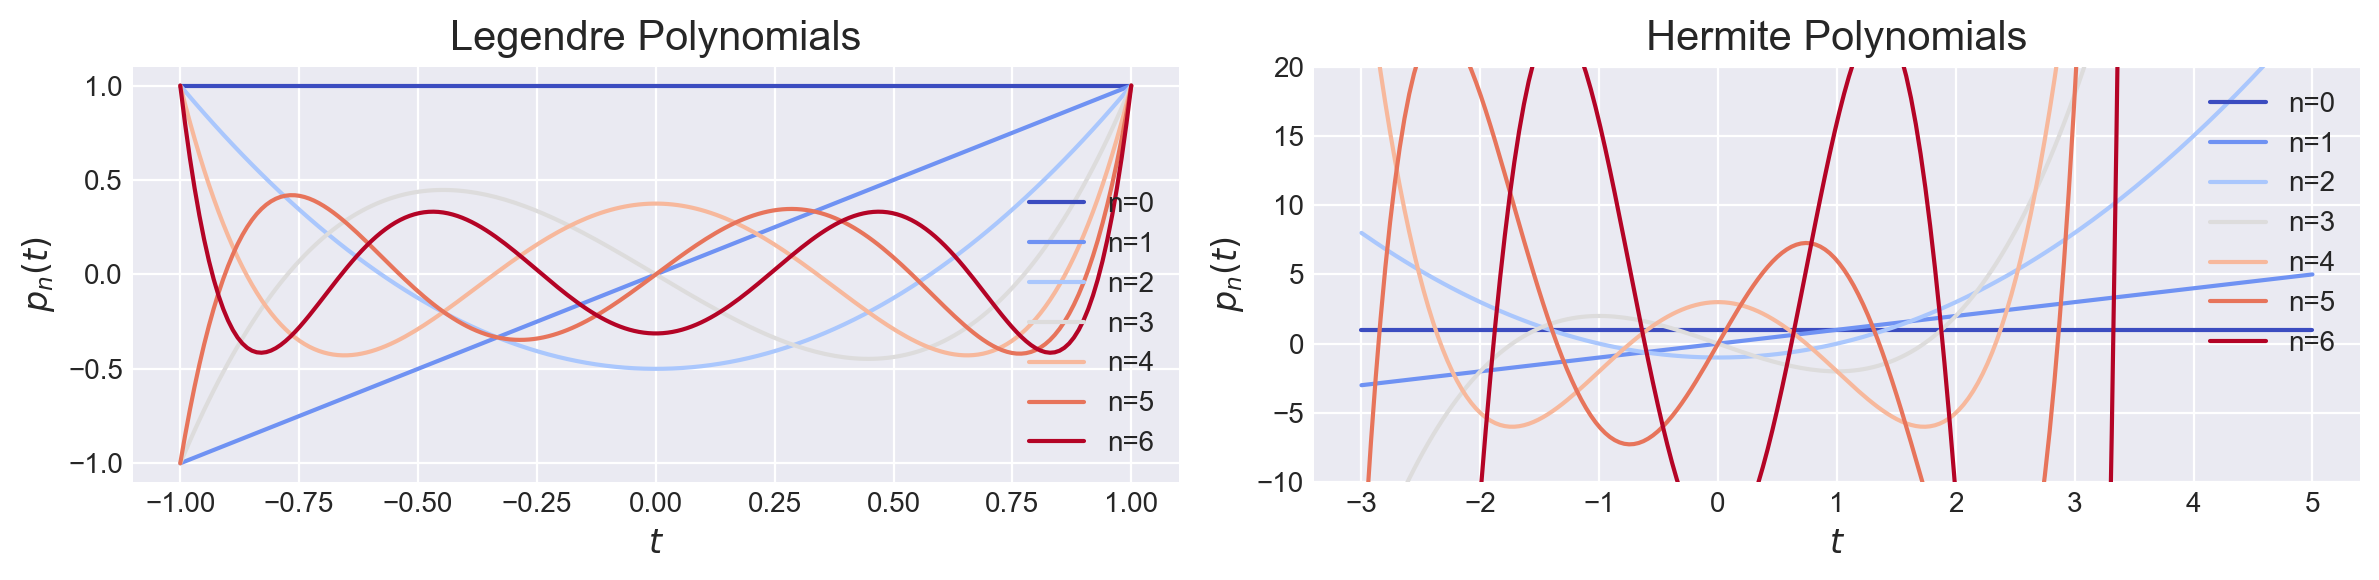

In [148]:
N = 7
cmap = plt.get_cmap('coolwarm')
colors = cmap(np.linspace(0, 1, N))

plt.figure(figsize=(12, 3), dpi=200)
plt.subplot(1, 2, 1)
t_grid = np.linspace(-1, 1, 200)
poly = Legendre()
for n in range(N):
    plt.plot(t_grid, poly.P(n)(t_grid), color=colors[n], label=f'n={n}')
plt.legend(loc='best')
plt.title('Legendre Polynomials', fontsize=15)
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$p_n(t)$', fontsize=12)
plt.subplot(1, 2, 2)
t_grid = np.linspace(-3, 5, 200)
poly = Hermite(0, 1)
for n in range(N):
    plt.plot(t_grid, poly.P(n)(t_grid), color=colors[n], label=f'n={n}')
plt.ylim(-10, 20)
plt.legend(loc='upper right')
plt.title('Hermite Polynomials', fontsize=15)
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$p_n(t)$', fontsize=12)
plt.tight_layout()
# plt.savefig('orthopoly.pdf')

### error estimates of Orthogonal polynomials and Fourier

In [132]:
N=16
length = 105
t_grid = np.linspace(-1, 1, length)
def x1(t):
    return np.cos(10*t) - np.sin(2*np.pi*t)
def x2(t):
    return np.sin(10*t) + np.exp(2*t) - t
def x3(t):
    return 2 * np.abs(2 * (t % 1) - 1) - 1

cmap = plt.get_cmap('coolwarm')
colors = cmap(np.linspace(0, 1, N))
n_arr = np.arange(2, N)

C:\Users\Besty\AppData\Local\Temp\ipykernel_18988\3443275906.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')
  0%|          | 0/16 [00:00<?, ?it/s]e:\File_VSCode\M3R\M3R_LMU\main_funcs.py:150: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  an = quad(lambda t: x(t)*P_n(t)*self.weight(t), self.x1, self.x2)[0]/snorm_n
100%|██████████| 16/16 [00:00<00:00, 84.68it/s] 


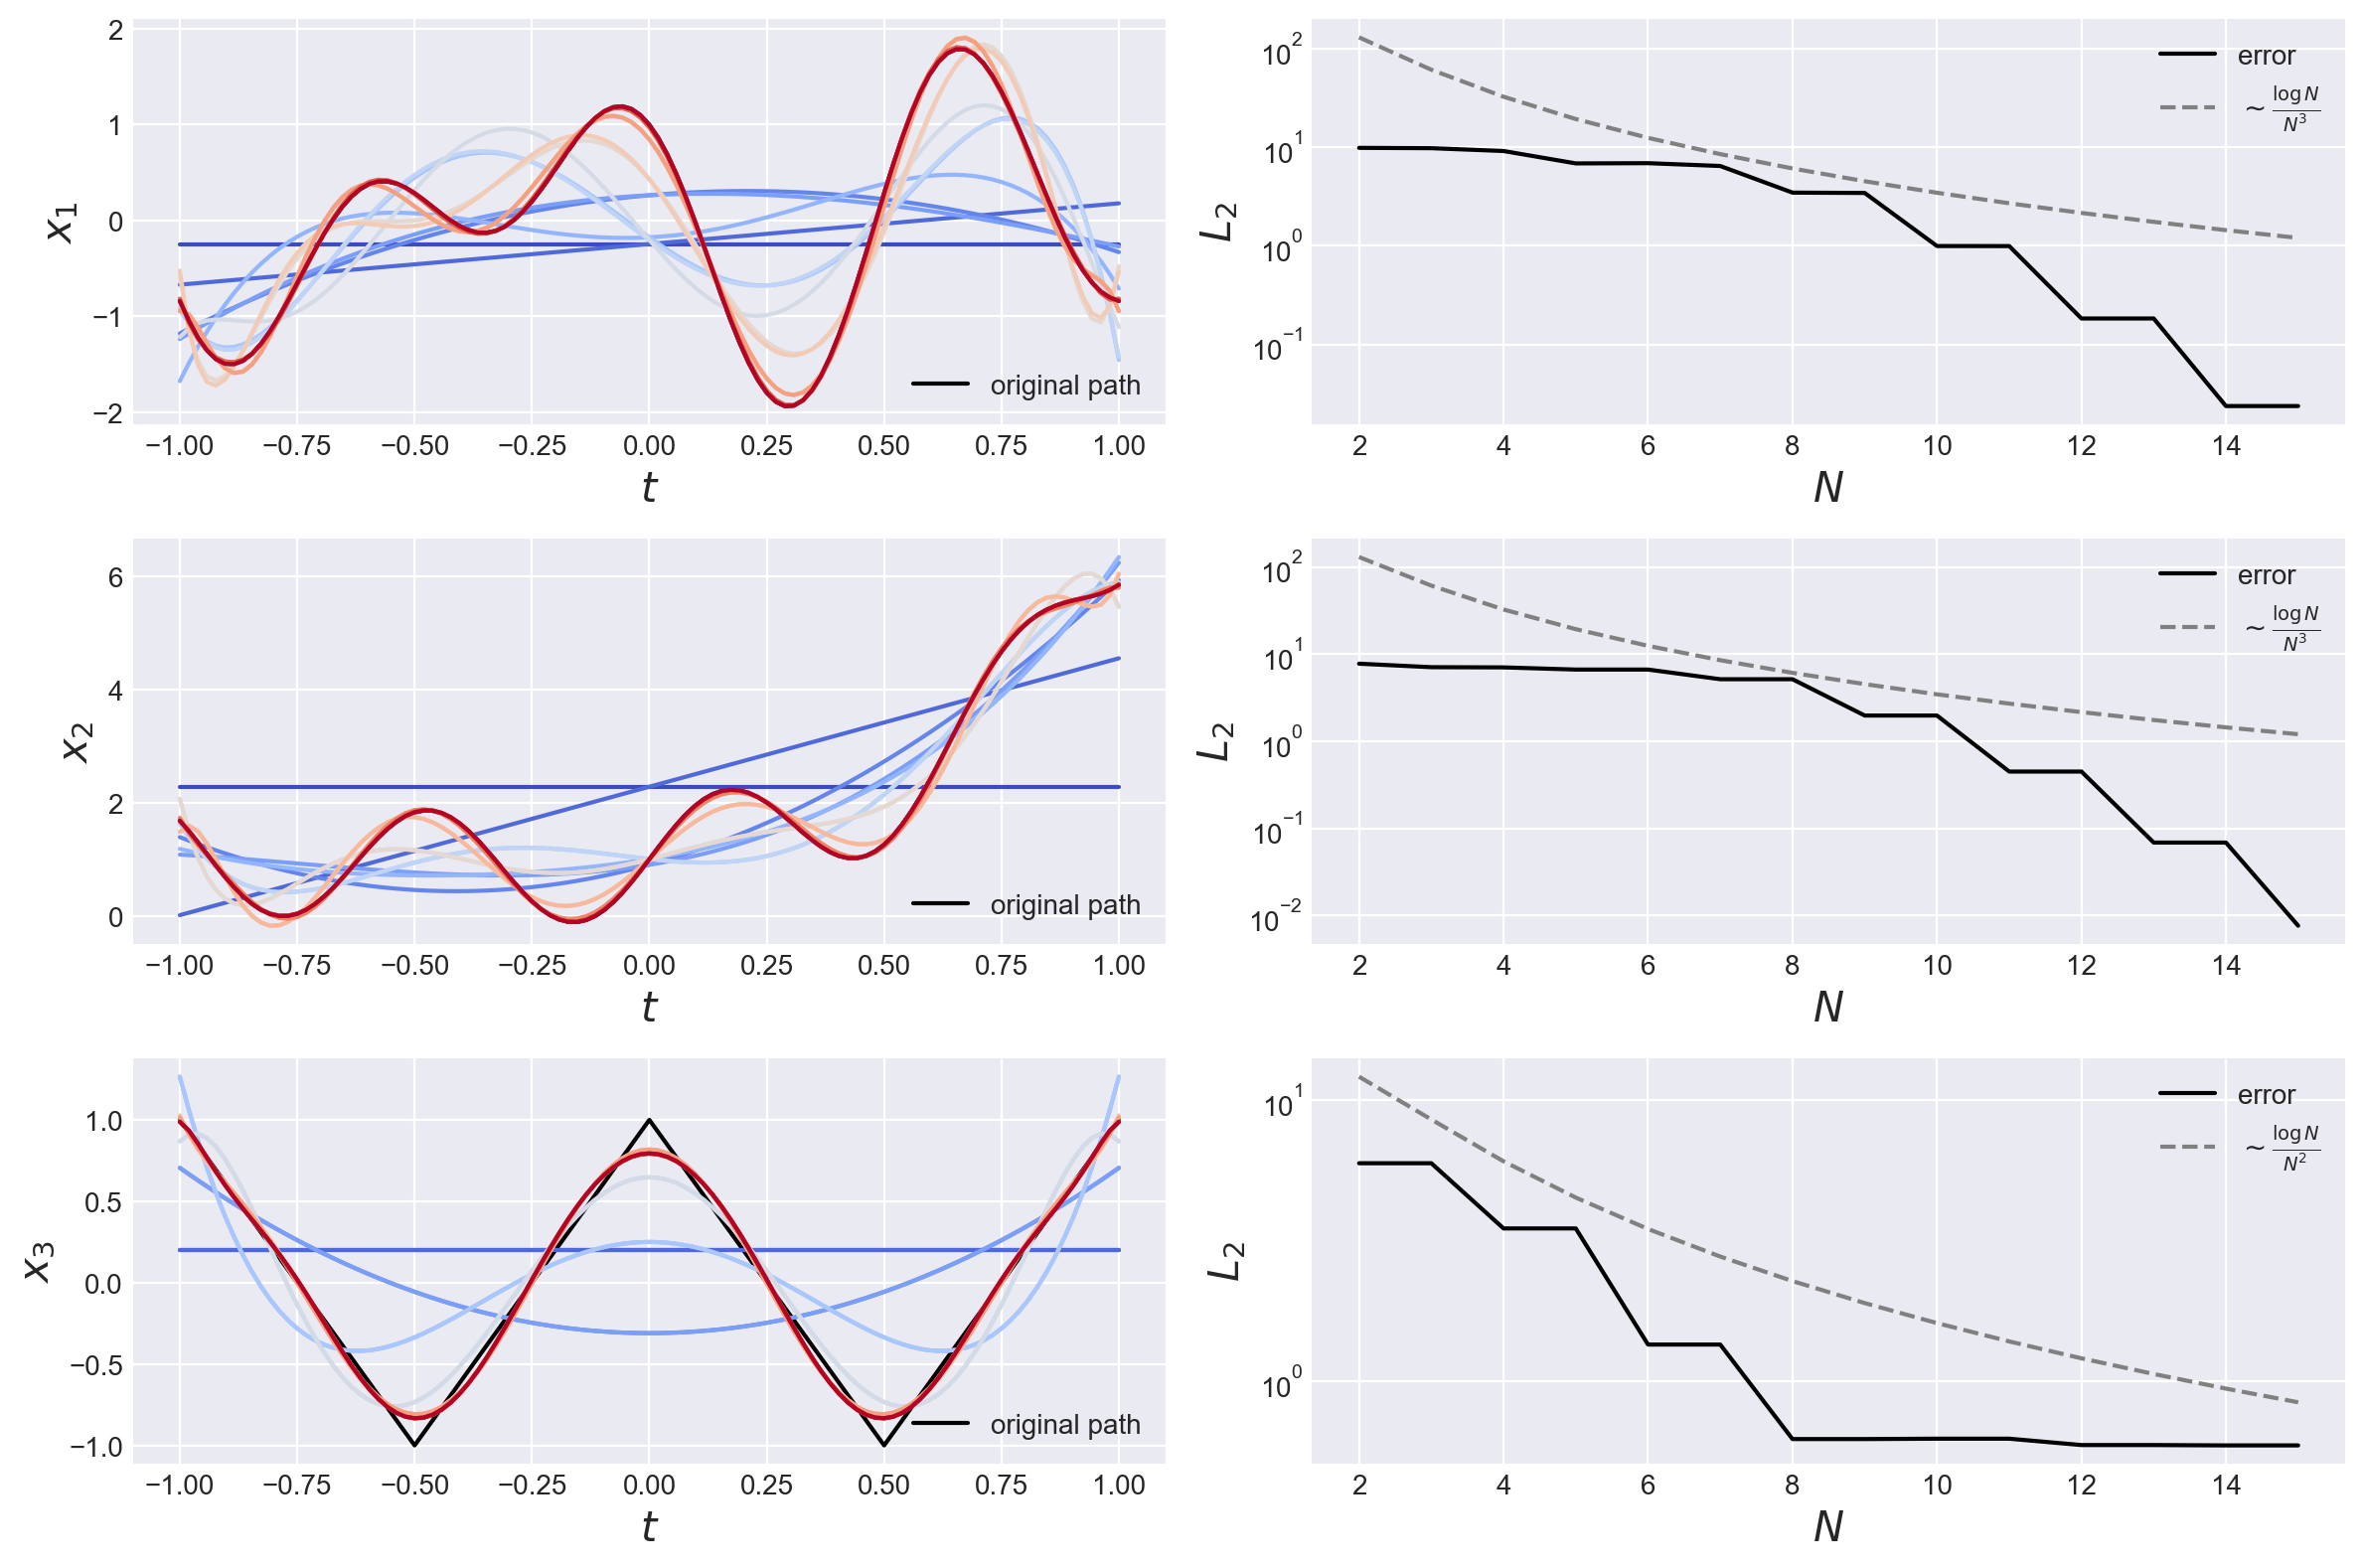

In [133]:
poly = Chebyshev()
plt.figure(figsize=(12, 8), dpi=200)

plt.subplot(3, 2, 1)
plt.plot(t_grid, x1(t_grid), color='black', label='original path')
for n in tqdm(range(N)):
    plt.plot(t_grid, poly.ploy2path(x1, n, t_grid), color=colors[n])
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_1$', fontsize=15)
plt.legend(loc='lower right')

plt.subplot(3, 2, 2)
plt.plot(n_arr, [np.linalg.norm(poly.ploy2path(x1, n, t_grid)-x1(t_grid)) for n in n_arr], color='black', label='error')
plt.plot(n_arr, 1500*np.log(n_arr)/n_arr**3, color='grey', label=r'$\sim\frac{\log N}{N^3}$', linestyle='--')
plt.yscale('log')
plt.xlabel(r'$N$', fontsize=15)
plt.ylabel(r'$L_{2}$', fontsize=15)
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(t_grid, x2(t_grid), color='black', label='original path')
for n in tqdm(range(N)):
    plt.plot(t_grid, poly.ploy2path(x2, n, t_grid), color=colors[n])
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_2$', fontsize=15)
plt.legend(loc='lower right')

plt.subplot(3, 2, 4)
plt.plot(n_arr, [np.linalg.norm(poly.ploy2path(x2, n, t_grid)-x2(t_grid)) for n in n_arr], color='black', label='error')
plt.plot(n_arr, 1500*np.log(n_arr)/n_arr**3, color='grey', label=r'$\sim\frac{\log N}{N^3}$', linestyle='--')
plt.yscale('log')
plt.xlabel(r'$N$', fontsize=15)
plt.ylabel(r'$L_{2}$', fontsize=15)
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(t_grid, x3(t_grid), color='black', label='original path')
for n in tqdm(range(N)):
    plt.plot(t_grid, poly.ploy2path(x3, n, t_grid), color=colors[n])
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_3$', fontsize=15)
plt.legend(loc='lower right')

plt.subplot(3, 2, 6)
plt.plot(n_arr, [np.linalg.norm(poly.ploy2path(x3, n, t_grid)-x3(t_grid)) for n in n_arr], color='black', label='error')
plt.plot(n_arr, 70*np.log(n_arr)/n_arr**2, color='grey', label=r'$\sim\frac{\log N}{N^2}$', linestyle='--')
plt.yscale('log')
plt.xlabel(r'$N$', fontsize=15)
plt.ylabel(r'$L_{2}$', fontsize=15)
plt.legend()
plt.tight_layout()
# plt.savefig('orthopoly_convergence.pdf')
plt.show()

C:\Users\Besty\AppData\Local\Temp\ipykernel_18988\1564770248.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')
100%|██████████| 14/14 [00:00<00:00, 2531.37it/s]


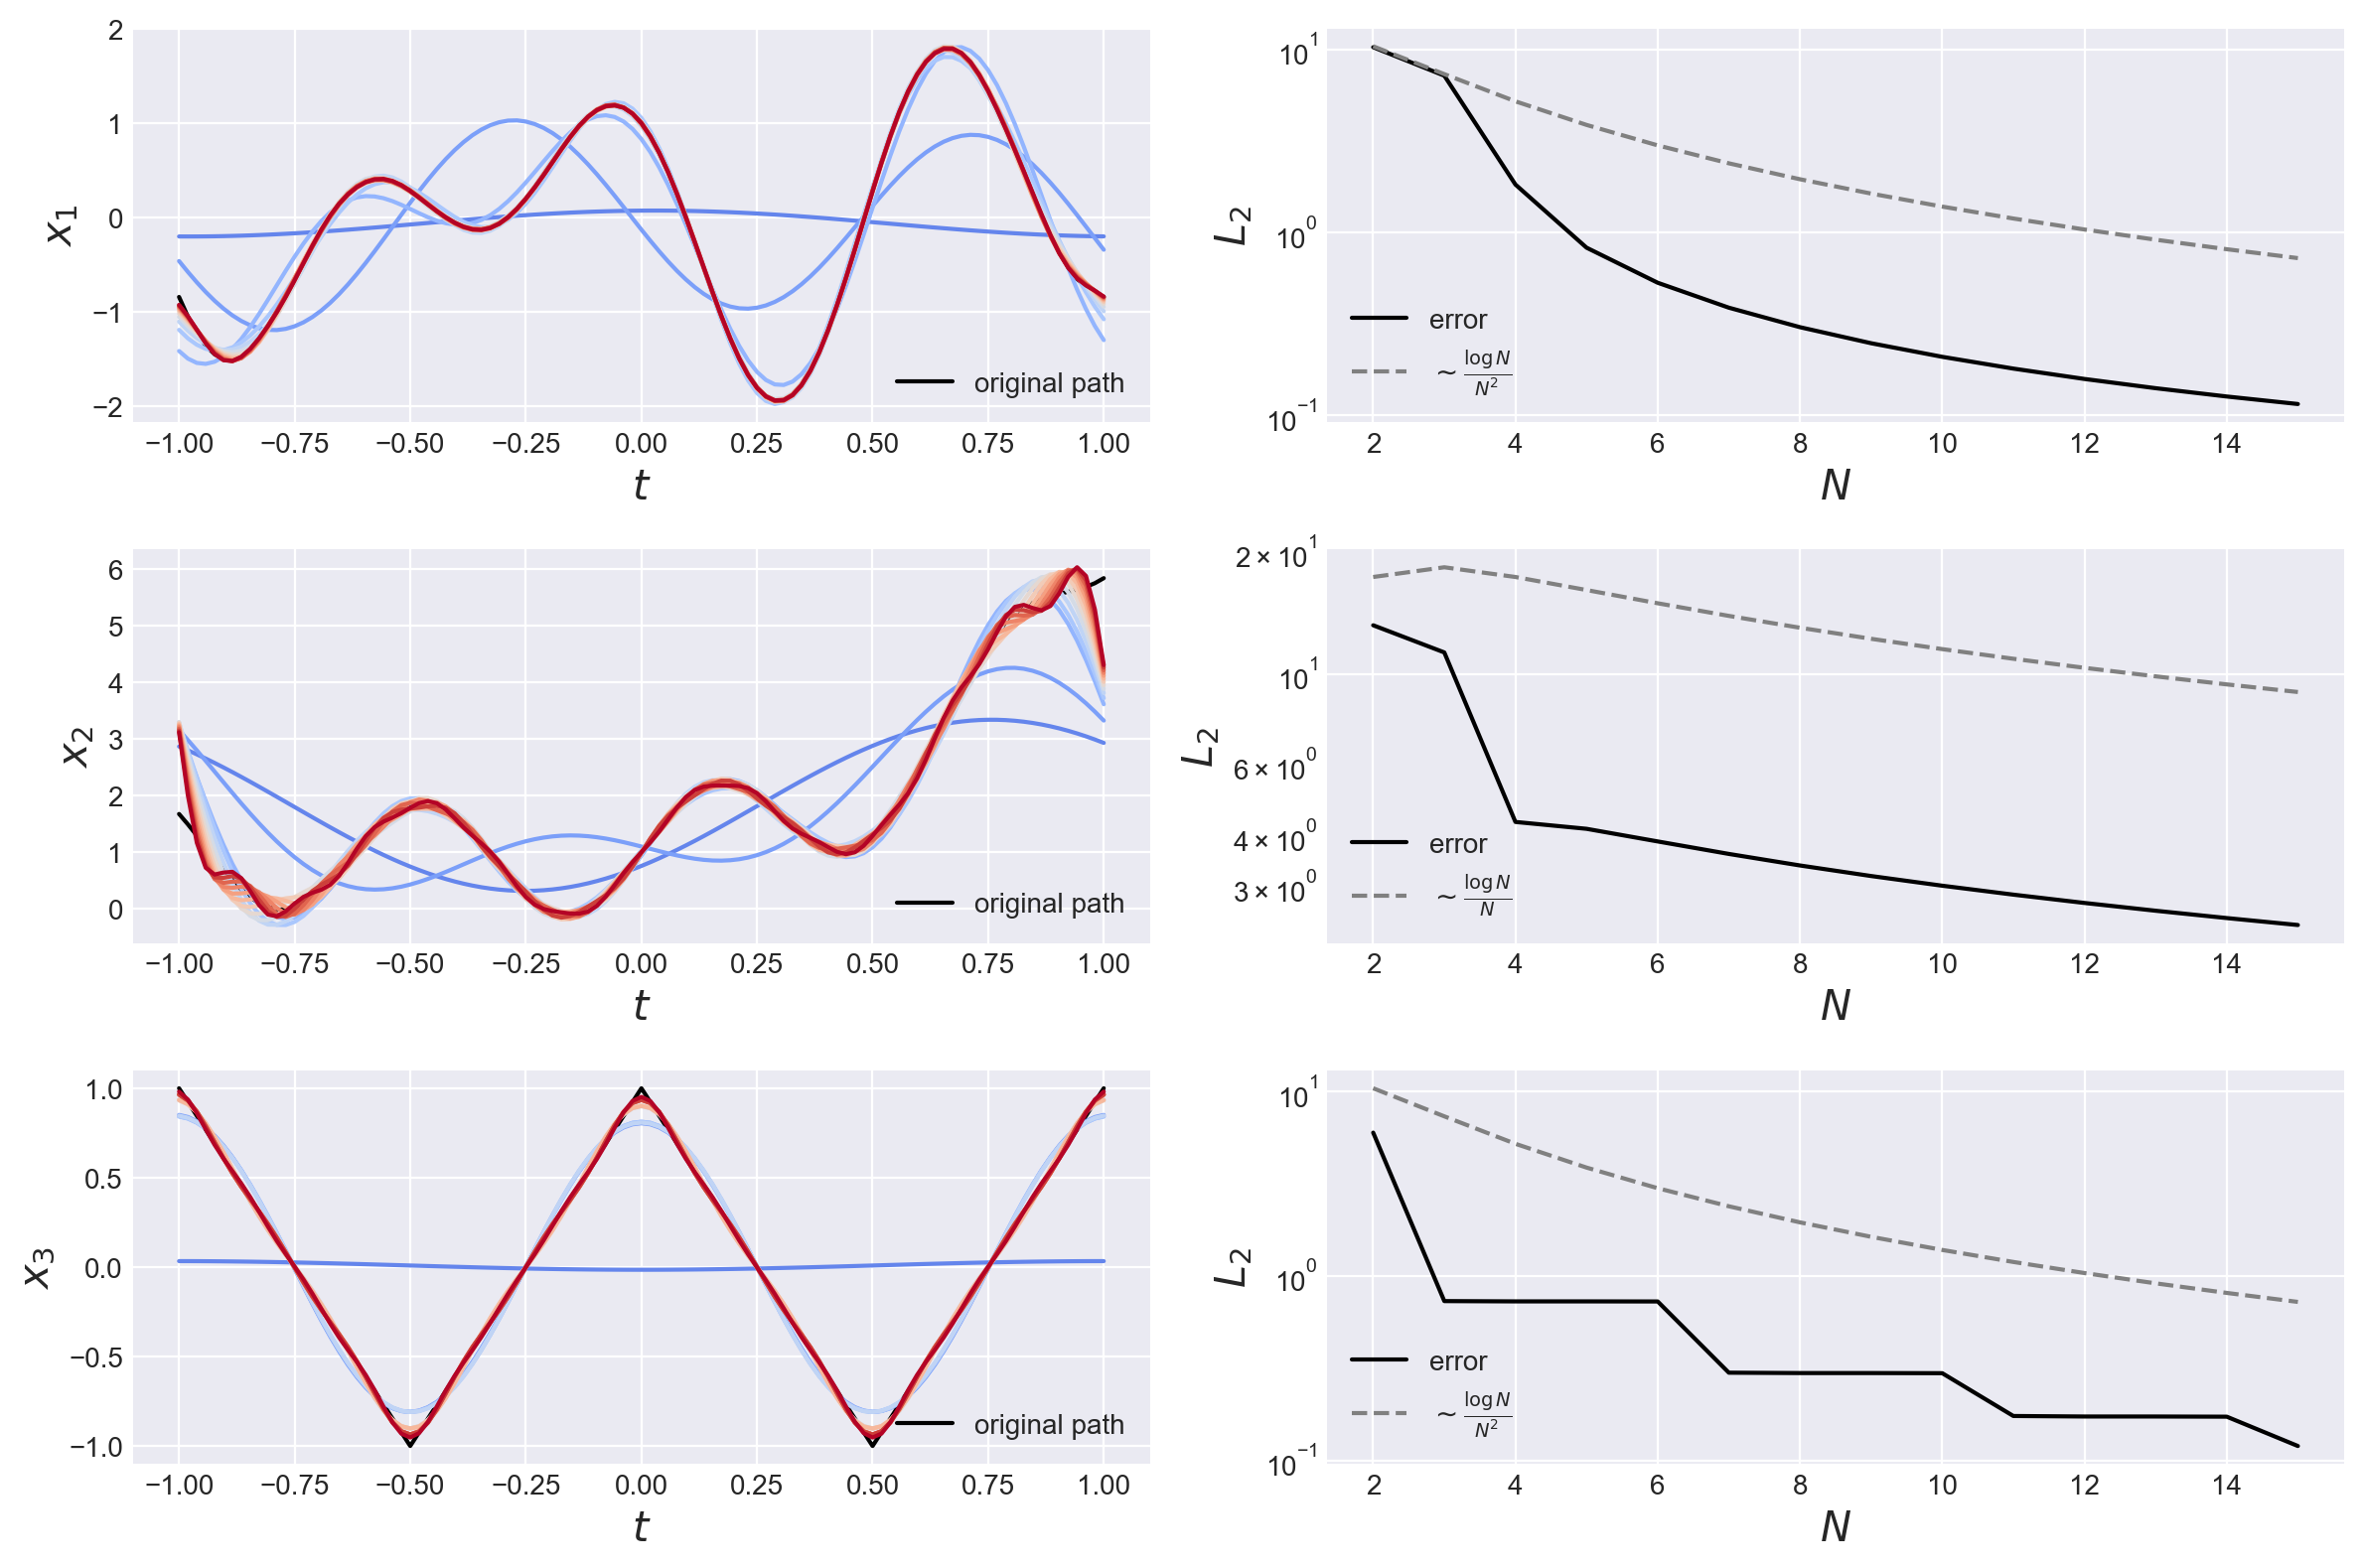

In [137]:
N=16
colors = cmap(np.linspace(0, 1, N))
n_arr = np.arange(2, N)

plt.figure(figsize=(12, 8), dpi=200)
plt.subplot(3, 2, 1)
path1 = x1(t_grid)
plt.plot(t_grid, path1, color='black', label='original path')
for n in tqdm(n_arr):
    plt.plot(t_grid, ifft_aug(fft_aug(path1, n), length, n), color=colors[n])
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_1$', fontsize=15)
plt.legend(loc='lower right')

plt.subplot(3, 2, 2)
plt.plot(n_arr, [np.linalg.norm(ifft_aug(fft_aug(path1, n), length, n)-path1) for n in n_arr], color='black', label='error')
plt.plot(n_arr, 60*np.log(n_arr)/n_arr**2, color='grey', label=r'$\sim\frac{\log N}{N^2}$', linestyle='--')
plt.yscale('log')
plt.xlabel(r'$N$', fontsize=15)
plt.ylabel(r'$L_{2}$', fontsize=15)
plt.legend(loc='lower left')

plt.subplot(3, 2, 3)
path2 = x2(t_grid)
plt.plot(t_grid, path2, color='black', label='original path')
for n in tqdm(n_arr):
    plt.plot(t_grid, ifft_aug(fft_aug(path2, n), length, n), color=colors[n])
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_2$', fontsize=15)
plt.legend(loc='lower right')

plt.subplot(3, 2, 4)
plt.plot(n_arr, [np.linalg.norm(ifft_aug(fft_aug(path2, n), length, n)-path2) for n in n_arr], color='black', label='error')
plt.plot(n_arr, 50*np.log(n_arr)/n_arr, color='grey', label=r'$\sim\frac{\log N}{N}$', linestyle='--')
plt.yscale('log')
plt.xlabel(r'$N$', fontsize=15)
plt.ylabel(r'$L_{2}$', fontsize=15)
plt.legend(loc='lower left')

plt.subplot(3, 2, 5)
path3 = x3(t_grid)
plt.plot(t_grid, path3, color='black', label='original path')
for n in tqdm(n_arr):
    plt.plot(t_grid, ifft_aug(fft_aug(path3, n), length, n), color=colors[n])
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_3$', fontsize=15)
plt.legend(loc='lower right')

plt.subplot(3, 2, 6)
plt.plot(n_arr, [np.linalg.norm(ifft_aug(fft_aug(path3, n), length, n)-path3) for n in n_arr], color='black', label='error')
plt.plot(n_arr, 60*np.log(n_arr)/n_arr**2, color='grey', label=r'$\sim\frac{\log N}{N^2}$', linestyle='--')
plt.yscale('log')
plt.xlabel(r'$N$', fontsize=15)
plt.ylabel(r'$L_{2}$', fontsize=15)
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('fourier_convergence.pdf')
plt.show()

### Inversion visualisation

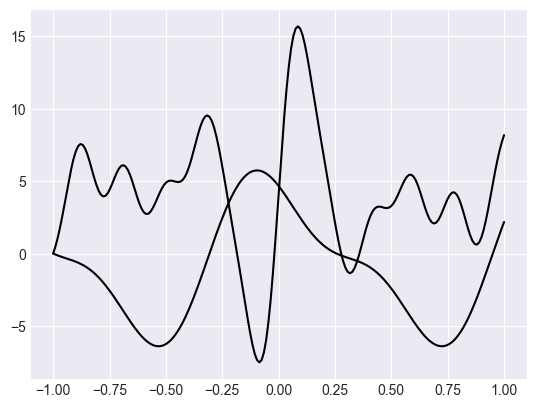

In [139]:
N = 10
length = 200
t_grid = np.linspace(-1, 1, length)
def x1_(t):
    return 5*np.cos(5*t) - 2*np.sin(10*t)
# x1_ = random_poly_generator(seed=np.random.randint(20, 100))
def x1(t):
    return x1_(t) - x1_(-1)
x2_ = random_sine_generator(seed=1911)
# x2_ = random_trig_generator(seed=np.random.randint(20, 100))
def x2(t):
    return x2_(t) - x2_(-1)
cmap = plt.get_cmap('coolwarm')
colors = cmap(np.linspace(0, 1, N))
plt.plot(t_grid, x1(t_grid), color='black', label='path')
plt.plot(t_grid, x2(t_grid), color='black', label='path')

np.random.seed(1531)
data1 = sig_Dataset(500, n=200, f_depth=N, s_depth=6, path='low_freq')
reg1 = LinearRegression().fit(data1.inputs, data1.labels)
data2 = sig_Dataset(500, n=200, f_depth=N, s_depth=6, path='high_freq')
reg2 = LinearRegression().fit(data2.inputs, data2.labels)

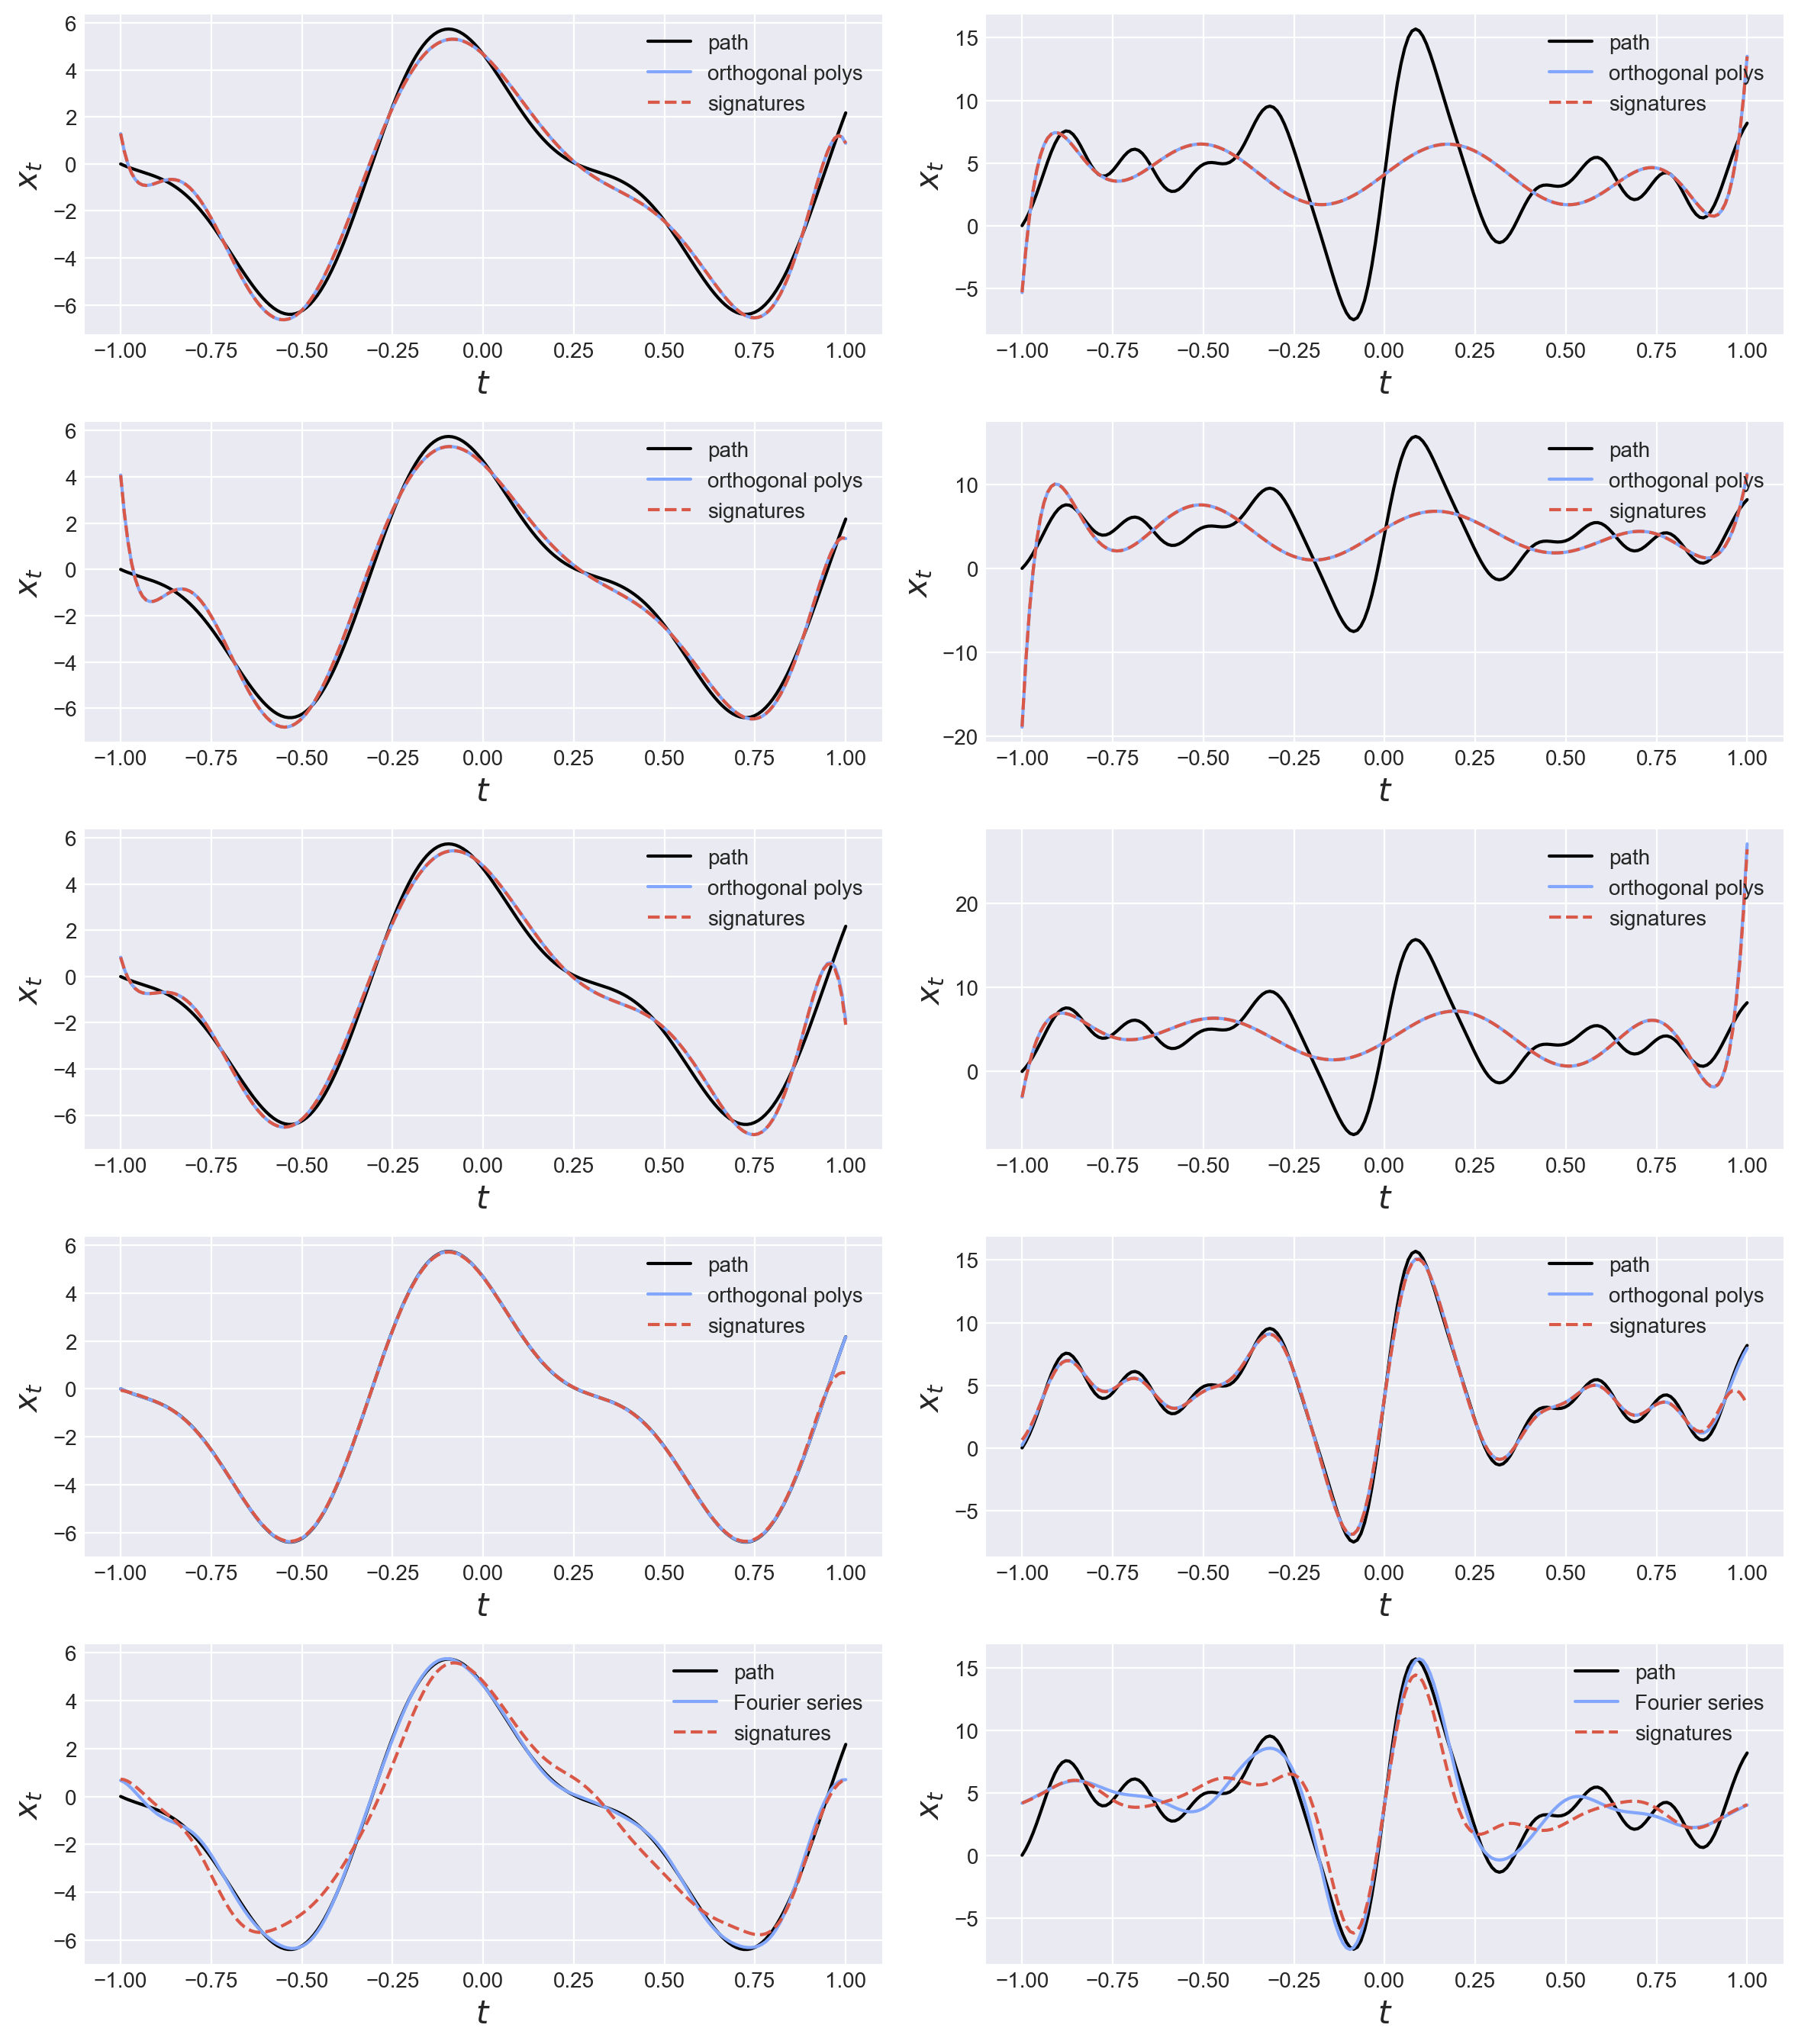

In [142]:
plt.figure(figsize=(12, 13.5), dpi=200)

poly = Legendre()
path_time1 = np.c_[t_grid, x1(t_grid)*poly.weight(t_grid)]
sig1 = signature_of_path_iisignature(path_time1, N+2)
path_time2 = np.c_[t_grid, x2(t_grid)*poly.weight(t_grid)]
sig2 = signature_of_path_iisignature(path_time2, N+2)

plt.subplot(5, 2, 1)
plt.plot(t_grid, x1(t_grid), color='black', label='path')
plt.plot(t_grid, poly.ploy2path(x1, N, t_grid), label='orthogonal polys', color=colors[2], linestyle='-')
plt.plot(t_grid, poly.sig2path(sig1, N, t_grid), label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='upper right')
plt.subplot(5, 2, 2)
plt.plot(t_grid, x2(t_grid), color='black', label='path')
plt.plot(t_grid, poly.ploy2path(x2, N, t_grid), label='orthogonal polys', color=colors[2], linestyle='-')
plt.plot(t_grid, poly.sig2path(sig2, N, t_grid), label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='upper right')

poly = Jacobi(0, 0.5)
path_time1 = np.c_[t_grid, x1(t_grid)*poly.weight(t_grid)]
sig1 = signature_of_path_iisignature(path_time1, N+2)
path_time2 = np.c_[t_grid, x2(t_grid)*poly.weight(t_grid)]
sig2 = signature_of_path_iisignature(path_time2, N+2)

plt.subplot(5, 2, 3)
plt.plot(t_grid, x1(t_grid), color='black', label='path')
plt.plot(t_grid, poly.ploy2path(x1, N, t_grid), label='orthogonal polys', color=colors[2], linestyle='-')
plt.plot(t_grid, poly.sig2path(sig1, N, t_grid), label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='upper right')
plt.subplot(5, 2, 4)
plt.plot(t_grid, x2(t_grid), color='black', label='path')
plt.plot(t_grid, poly.ploy2path(x2, N, t_grid), label='orthogonal polys', color=colors[2], linestyle='-')
plt.plot(t_grid, poly.sig2path(sig2, N, t_grid), label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='upper right')

poly = Jacobi(0.5, 0)
path_time1 = np.c_[t_grid, x1(t_grid)*poly.weight(t_grid)]
sig1 = signature_of_path_iisignature(path_time1, N+2)
path_time2 = np.c_[t_grid, x2(t_grid)*poly.weight(t_grid)]
sig2 = signature_of_path_iisignature(path_time2, N+2)

plt.subplot(5, 2, 5)
plt.plot(t_grid, x1(t_grid), color='black', label='path')
plt.plot(t_grid, poly.ploy2path(x1, N, t_grid), label='orthogonal polys', color=colors[2], linestyle='-')
plt.plot(t_grid, poly.sig2path(sig1, N, t_grid), label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='upper right')
plt.subplot(5, 2, 6)
plt.plot(t_grid, x2(t_grid), color='black', label='path')
plt.plot(t_grid, poly.ploy2path(x2, N, t_grid), label='orthogonal polys', color=colors[2], linestyle='-')
plt.plot(t_grid, poly.sig2path(sig2, N, t_grid), label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='upper right')

plt.subplot(5, 2, 7)
plt.plot(t_grid, x1(t_grid), color='black', label='path')
plt.plot(t_grid, point_coef(x1, t_grid, 2, 0.05), label='orthogonal polys', color=colors[2], linestyle='-')
plt.plot(t_grid, point_sig(x1, t_grid, 2, 0.05), label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='upper right')
plt.subplot(5, 2, 8)
plt.plot(t_grid, x2(t_grid), color='black', label='path')
plt.plot(t_grid, point_coef(x2, t_grid, 2, 0.05), label='orthogonal polys', color=colors[2], linestyle='-')
plt.plot(t_grid, point_sig(x2, t_grid, 2, 0.05), label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='upper right')

coef1 = fft_aug(x1(t_grid), N)
reg_coef1 = reg1.predict(sig_AT(x1(t_grid).reshape(1, -1), 6, time=np.linspace(-1, 1, 200)))
coef2 = fft_aug(x2(t_grid), N)
reg_coef2 = reg2.predict(sig_AT(x2(t_grid).reshape(1, -1), 6, time=np.linspace(-1, 1, 200)))

plt.subplot(5, 2, 9)
plt.plot(t_grid, x1(t_grid), color='black', label='path')
plt.plot(t_grid, ifft_aug(coef1, n=200, f_depth=N), label='Fourier series', color=colors[2], linestyle='-')
plt.plot(t_grid, ifft_aug(reg_coef1, n=200, f_depth=N).flatten(), label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='upper right')

plt.subplot(5, 2, 10)
plt.plot(t_grid, x2(t_grid), color='black', label='path')
plt.plot(t_grid, ifft_aug(coef2, n=200, f_depth=N), label='Fourier series', color=colors[2], linestyle='-')
plt.plot(t_grid, ifft_aug(reg_coef2, n=200, f_depth=N).flatten(), label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='upper right')

plt.tight_layout()
# plt.savefig('visual_sig_inv.pdf')

### Approximation quality of orthogonal polynomials and Fourier series

In [149]:
length = 200
iter_num = 10
d_range = range(2, 13)
t_grid = np.linspace(-1, 1, length)
poly_dict = {'Legendre': {'poly': Legendre(), 'error': np.zeros((2, d_range[-1]-d_range[0]+1))},
             'Jacobi(0, 0.5)': {'poly': Jacobi(0, 0.5), 'error': np.zeros((2, d_range[-1]-d_range[0]+1))},
             'Jacobi(0.5, 0)': {'poly': Jacobi(0.5, 0), 'error': np.zeros((2, d_range[-1]-d_range[0]+1))}}
hermite_dict = {'Hermite $\epsilon=0.1$': {'eps': 0.1, 'error': np.zeros((2, d_range[-1]-d_range[0]+1))},
             'Hermite $\epsilon=0.05$': {'eps': 0.05, 'error': np.zeros((2, d_range[-1]-d_range[0]+1))},
             'Hermite $\epsilon=0.01$': {'eps': 0.01, 'error': np.zeros((2, d_range[-1]-d_range[0]+1))}}
fourier_dict = {'Fourier': {'poly': Fourier(t_grid), 'error': np.zeros((2, d_range[-1]-d_range[0]+1))}}

for n in tqdm(d_range):
    for i in range(iter_num):
        func = random_poly_generator(seed=np.random.randint(10, 100))
        for sub_dict in poly_dict.values():
            sub_dict['error'][0, n-d_range[0]] += np.linalg.norm(sub_dict['poly'].ploy2path(func, n, t_grid) - func(t_grid))
        for sub_dict in hermite_dict.values():
            sub_dict['error'][0, n-d_range[0]] += np.linalg.norm(point_coef(func, t_grid, n, eps=sub_dict['eps']) - func(t_grid))
        fourier_dict['Fourier']['error'][0, n-d_range[0]] += np.linalg.norm(ifft_aug(fft_aug(func(t_grid), n), length, n)-func(t_grid))
        func = random_trig_generator(seed=np.random.randint(10, 100))
        for sub_dict in poly_dict.values():
            sub_dict['error'][1, n-d_range[0]] += np.linalg.norm(sub_dict['poly'].ploy2path(func, n, t_grid) - func(t_grid))
        for sub_dict in hermite_dict.values():
            sub_dict['error'][1, n-d_range[0]] += np.linalg.norm(point_coef(func, t_grid, n, eps=sub_dict['eps']) - func(t_grid))
        fourier_dict['Fourier']['error'][1, n-d_range[0]] += np.linalg.norm(ifft_aug(fft_aug(func(t_grid), n), length, n)-func(t_grid))

100%|██████████| 11/11 [39:50<00:00, 217.33s/it]


In [150]:
total_dict = {**fourier_dict, **poly_dict, **hermite_dict}
for name, sub_dict in total_dict.items():
    sub_dict['error'] /= iter_num

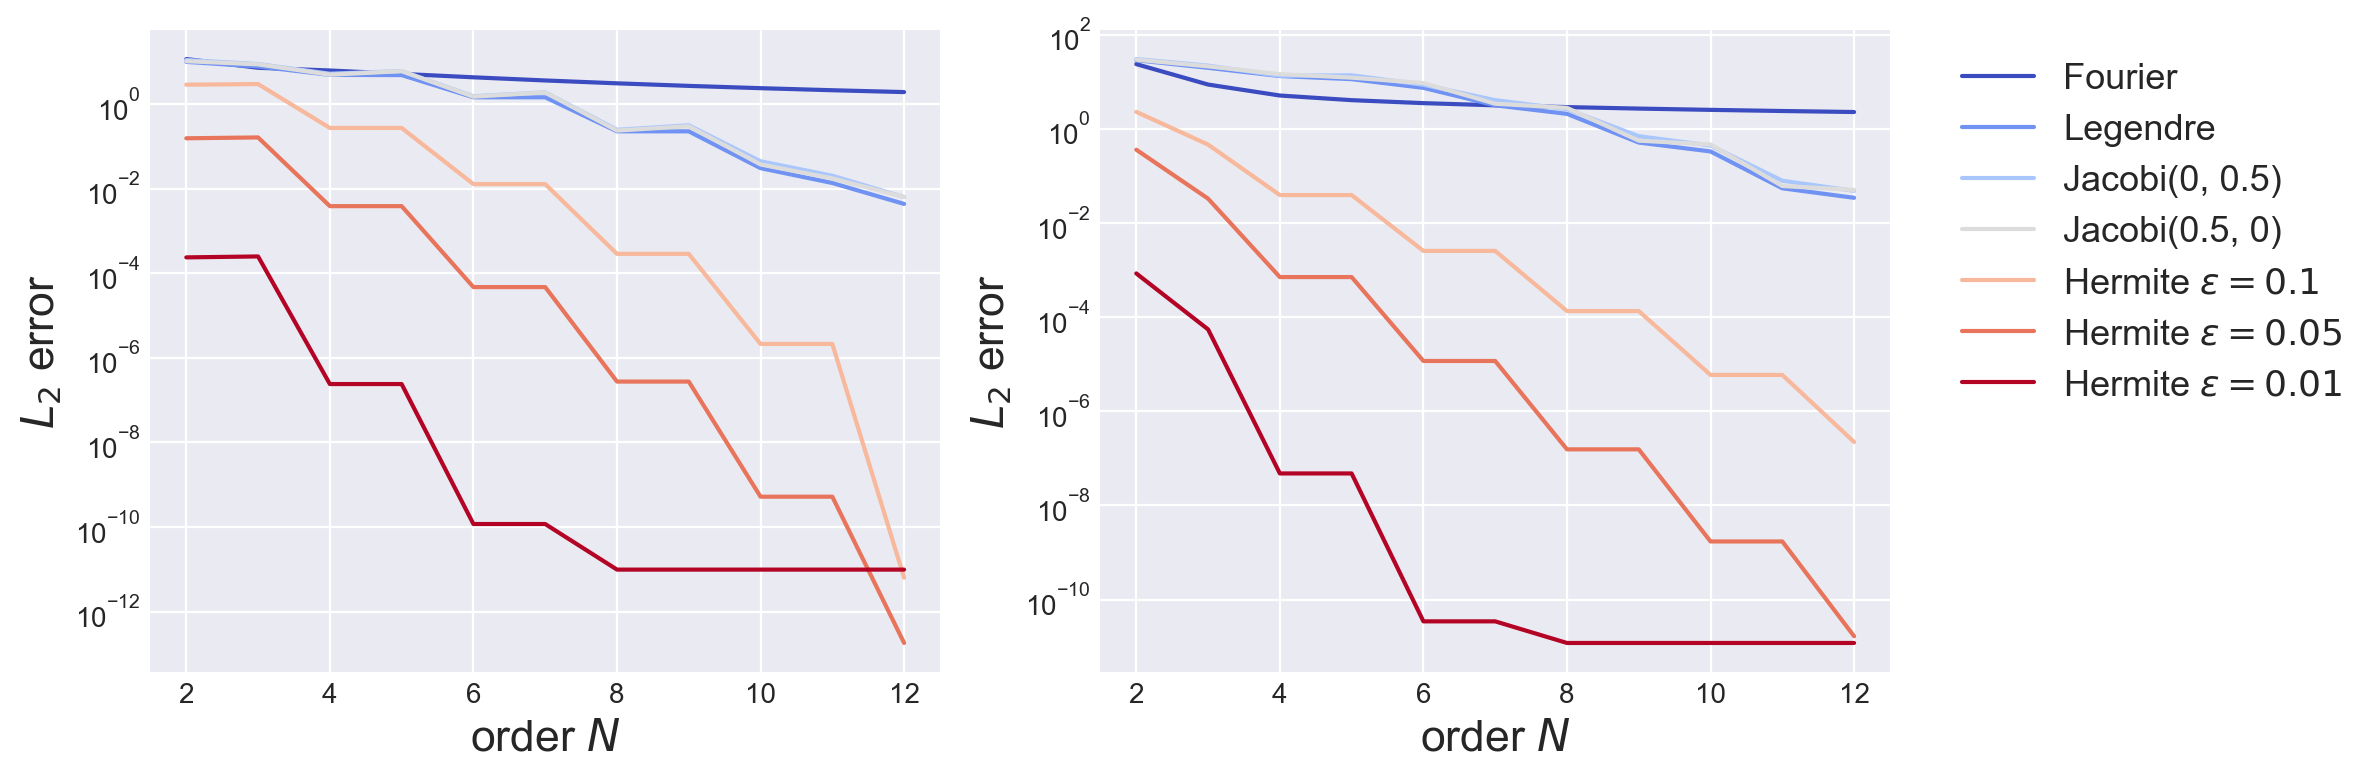

In [167]:
cmap = plt.get_cmap('coolwarm')
c = cmap(np.linspace(0, 1, len(total_dict)))

plt.figure(figsize=(12, 4), dpi=200)
plt.subplot(1, 2, 1)
for i, (name, sub_dict) in enumerate(total_dict.items()):
    plt.plot(d_range, sub_dict['error'][0], label=name, color=c[i])
plt.yscale('log')
plt.xlabel(r'order $N$', fontsize=16)
plt.ylabel(r'$L_2$ error', fontsize=16)
plt.subplot(1, 2, 2)
for i, (name, sub_dict) in enumerate(total_dict.items()):
    plt.plot(d_range, sub_dict['error'][1], label=name, color=c[i])

# Place the legend outside of the plot area on the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)

plt.yscale('log')
plt.xlabel(r'order $N$', fontsize=16)
plt.ylabel(r'$L_2$ error', fontsize=16)
plt.tight_layout()
plt.savefig('approx_error.pdf', bbox_inches='tight')

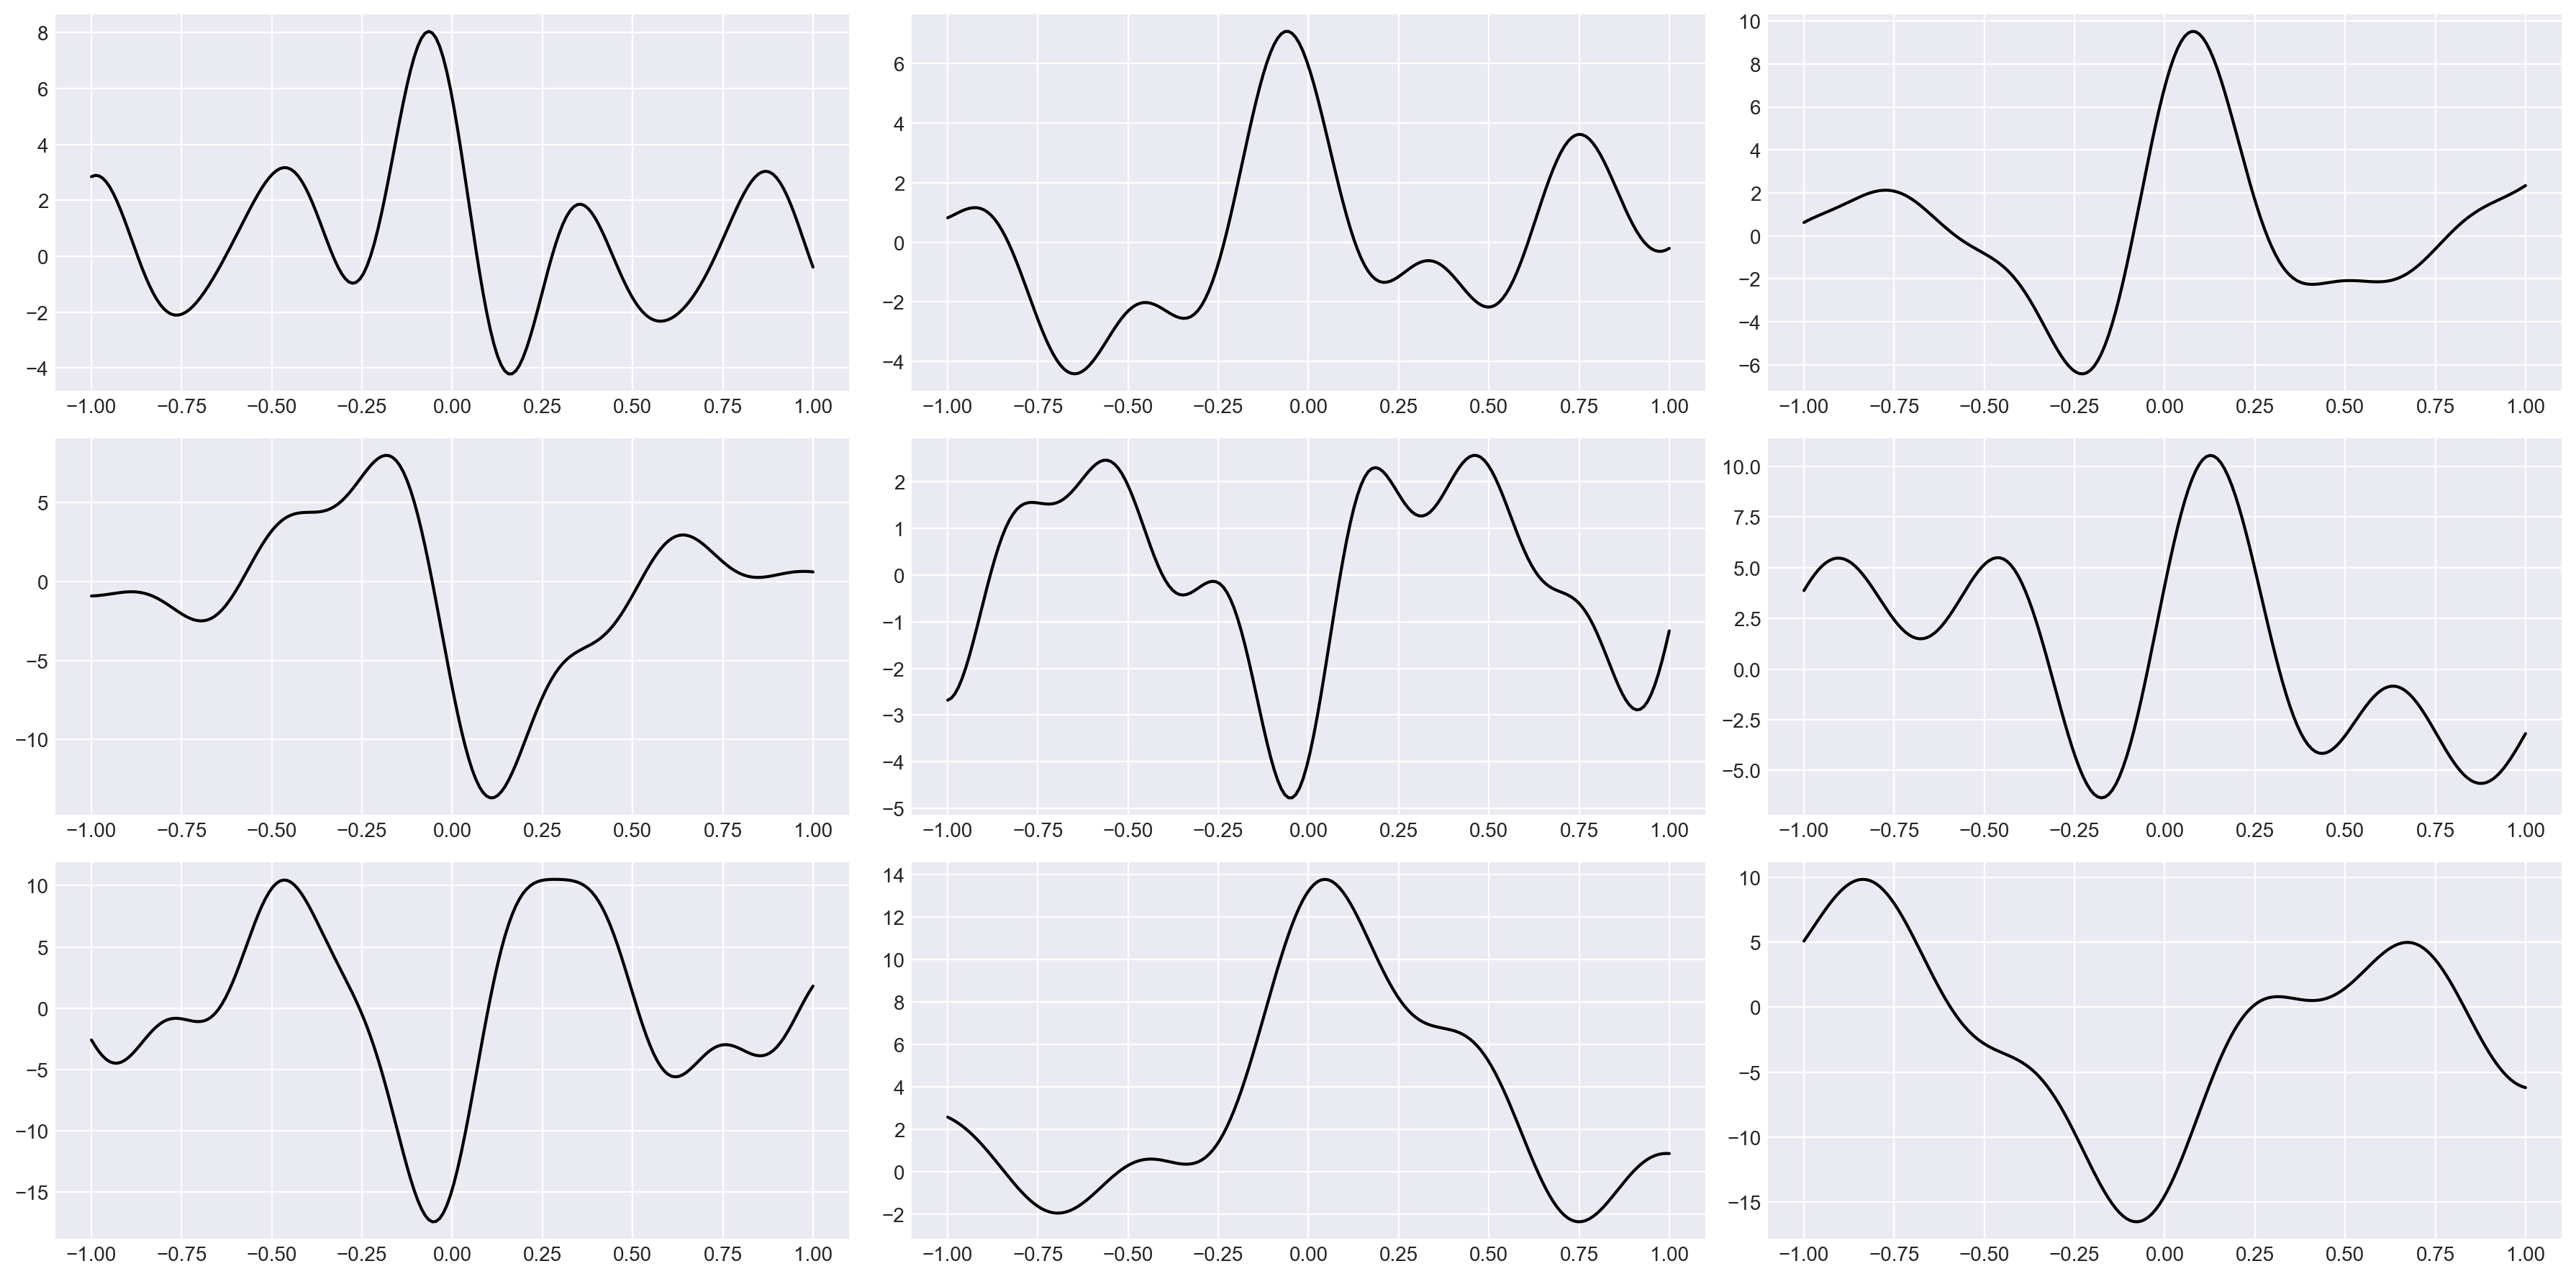

In [187]:
t_grid = np.linspace(-1, 1, 200)

plt.figure(figsize=(18, 9), dpi=200)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.plot(t_grid, random_trig_generator(np.random.randint(100000))(t_grid), color='black')
plt.tight_layout()
# plt.savefig('samples_trig.pdf')

### Error comparison for signature inversion

In [41]:
length = 200
iter_num = 15
d_range = range(1, 14)
t_grid = np.linspace(-1, 1, length)
poly_dict_inv = {'Legendre': {'poly': Legendre(), 'error': np.zeros((2, d_range[-1]-d_range[0]+1)), 'time': np.zeros((2, d_range[-1]-d_range[0]+1))},
             'Jacobi(0, 0.5)': {'poly': Jacobi(0, 0.5), 'error': np.zeros((2, d_range[-1]-d_range[0]+1)), 'time': np.zeros((2, d_range[-1]-d_range[0]+1))},
             'Jacobi(0.5, 0)': {'poly': Jacobi(0.5, 0), 'error': np.zeros((2, d_range[-1]-d_range[0]+1)), 'time': np.zeros((2, d_range[-1]-d_range[0]+1))}}
hermite_dict_inv = {'Hermite $\epsilon=0.05$': {'eps': 0.025, 'error': np.zeros((2, d_range[-1]-d_range[0]+1)), 'time': np.zeros((2, d_range[-1]-d_range[0]+1))}}
# fourier_dict_inv = {'Fourier': {'error': np.zeros((2, (2, d_range[-1]-d_range[0]+1)))}}

for n in tqdm(d_range):
    for i in range(iter_num):
        # func1 = random_poly_generator(seed=np.random.randint(10, 10000))
        # def func(t):
        #     return func1(t)-func1(-1.0)
        # for sub_dict in poly_dict_inv.values():
        #     start = time.time()
        #     path_time = np.c_[t_grid, func(t_grid)*sub_dict['poly'].weight(t_grid)]
        #     sig = signature_of_path_iisignature(path_time, n+2)
        #     sub_dict['error'][0, n-d_range[0]] += np.linalg.norm(sub_dict['poly'].sig2path(sig, n, t_grid) - func(t_grid))
        #     end = time.time()
        #     sub_dict['time'][0, n-d_range[0]] = end - start
        # if n<=7:
        #     start = time.time()
        #     hermite_dict_inv['Hermite $\epsilon=0.05$']['error'][0, n-d_range[0]] += np.linalg.norm(point_sig(func, np.linspace(-1, 1.3, 230), n, eps=0.025)[:200] - func(t_grid))
        #     end = time.time()
        #     hermite_dict_inv['Hermite $\epsilon=0.05$']['time'][0, n-d_range[0]] = end - start


        func2 = random_trig_generator(seed=np.random.randint(10, 10000))
        def func(t):
            return func2(t)-func2(-1.0)
        for sub_dict in poly_dict_inv.values():
            start = time.time()
            path_time = np.c_[t_grid, func(t_grid)*sub_dict['poly'].weight(t_grid)]
            sig = signature_of_path_iisignature(path_time, n+2)
            sub_dict['error'][1, n-d_range[0]] += np.linalg.norm(sub_dict['poly'].sig2path(sig, n, t_grid) - func(t_grid))
            end = time.time()
            sub_dict['time'][1, n-d_range[0]] = end - start
        if n<=7:
            start = time.time()
            hermite_dict_inv['Hermite $\epsilon=0.05$']['error'][1, n-d_range[0]] += np.linalg.norm(point_sig(func, np.linspace(-1, 1.3, 230), n, eps=0.025)[:200] - func(t_grid))
            end = time.time()
            hermite_dict_inv['Hermite $\epsilon=0.05$']['time'][1, n-d_range[0]] = end - start
        # data = sig_Dataset(500, 200, f_depth=n, s_depth=6, path='trig')
        # reg = LinearRegression().fit(data.inputs, data.labels)
        # coef = fft_aug(func(t_grid), n)
        # reg_coef = reg.predict(sig_AT(func(t_grid).reshape(1, -1), 6, time=np.linspace(-1, 1, 200)))
        # fourier_dict_inv['Fourier']['error'][1, n-d_range[0]] += np.linalg.norm(ifft_aug(reg_coef, length, n)-func(t_grid))

total_dict_inv = {**poly_dict_inv, **hermite_dict_inv}
for name, sub_dict in total_dict_inv.items():
    sub_dict['error'] /= iter_num
    sub_dict['time'] /= iter_num

100%|██████████| 13/13 [08:49<00:00, 40.75s/it]


In [44]:
# cmap = plt.get_cmap('coolwarm')
# c = cmap(np.linspace(0, 1, len(total_dict_inv)))
# h = 'Hermite $\epsilon=0.05$'

# plt.figure(figsize=(12, 6), dpi=200)
# plt.style.use('seaborn-darkgrid')
# plt.subplot(2, 2, 1)
# for i, (name, sub_dict) in enumerate(poly_dict_inv.items()):
#     plt.plot(d_range, sub_dict['error'][0], label=name, color=c[i])
# plt.plot(d_range[:7], hermite_dict_inv[h]['error'][0, :7], label=h, color=c[-1])
# plt.legend()
# plt.yscale('log')
# plt.xlabel(r'order $N$', fontsize=15)
# plt.ylabel(r'$L_2$ error', fontsize=15)

# plt.subplot(2, 2, 2)
# for i, (name, sub_dict) in enumerate(poly_dict_inv.items()):
#     plt.plot(d_range, sub_dict['error'][1], label=name, color=c[i])
# plt.plot(d_range[:7], hermite_dict_inv[h]['error'][1, :7], label=h, color=c[-1])
# plt.legend()
# plt.yscale('log')
# plt.xlabel(r'order $N$', fontsize=15)
# plt.ylabel(r'$L_2$ error', fontsize=15)

# cmap1 = plt.get_cmap('cool_r')
# c1 = cmap1(np.linspace(0, 1, len(d_range)))
# plt.subplot(2, 2, 3)
# for i, (name, sub_dict) in enumerate(poly_dict_inv.items()):
#     plt.plot(sub_dict['time'][0], sub_dict['error'][0], label=name, color=c[i])
#     plt.scatter(sub_dict['time'][0], sub_dict['error'][0], color=c1, s=30)
# plt.plot(hermite_dict_inv[h]['time'][0, :7], hermite_dict_inv[h]['error'][0, :7], label=h, color=c[-1])
# plt.scatter(hermite_dict_inv[h]['time'][0, :7], hermite_dict_inv[h]['error'][0, :7], color=c1[:7], s=30)
# sm = plt.cm.ScalarMappable(cmap=cmap1, norm=plt.Normalize(vmin=d_range[0], vmax=d_range[-1]))
# cbar = plt.colorbar(sm)
# cbar.set_label(r'order $N$', rotation=90, labelpad=-35)
# plt.legend()
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel(r'time', fontsize=15)
# plt.ylabel(r'$L_2$ error', fontsize=15)

# plt.subplot(2, 2, 4)
# for i, (name, sub_dict) in enumerate(poly_dict_inv.items()):
#     plt.plot(sub_dict['time'][1], sub_dict['error'][0], label=name, color=c[i])
#     plt.scatter(sub_dict['time'][1], sub_dict['error'][0], color=c1, s=30)
# plt.plot(hermite_dict_inv[h]['time'][1, :7], hermite_dict_inv[h]['error'][1, :7], label=h, color=c[-1])
# plt.scatter(hermite_dict_inv[h]['time'][1, :7], hermite_dict_inv[h]['error'][1, :7], color=c1[:7], s=30)
# sm = plt.cm.ScalarMappable(cmap=cmap1, norm=plt.Normalize(vmin=d_range[0], vmax=d_range[-1]))
# cbar = plt.colorbar(sm)
# cbar.set_label(r'order $N$', rotation=90, labelpad=-35)
# plt.legend()
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel(r'time', fontsize=15)
# plt.ylabel(r'$L_2$ error', fontsize=15)

# plt.tight_layout()
# plt.savefig('inv_error.pdf')

16.338659600650665


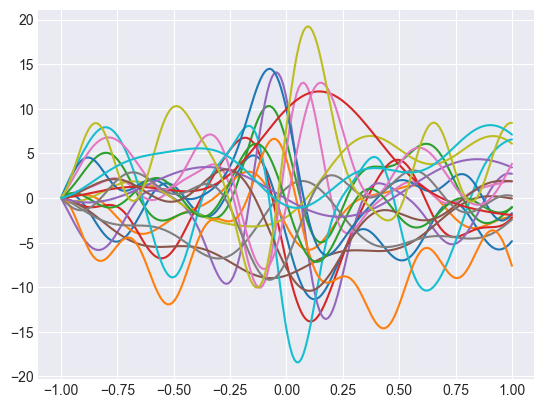

In [181]:
r = 0
iter_num = 20
for i in range(iter_num):
    func2 = random_trig_generator(seed=np.random.randint(100000000))
    def func(t):
        return func2(t)-func2(-1.0)
    plt.plot(t_grid, func(t_grid))
    r += max(func(t_grid))-min(func(t_grid))

print(r/iter_num)

### Example on rough path

e:\File_VSCode\M3R\m3r_venv\lib\site-packages\fbm\fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(
e:\File_VSCode\M3R\m3r_venv\lib\site-packages\fbm\fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(


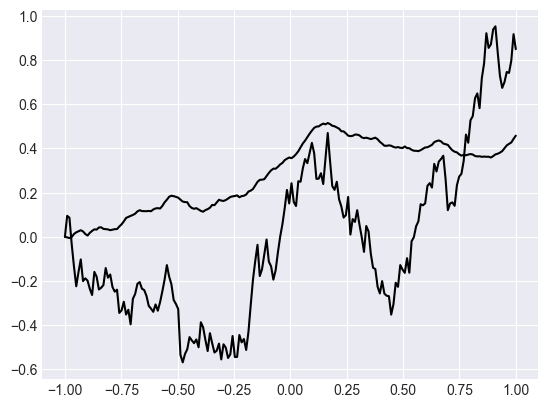

In [31]:
N = 10
length = 200
t_grid = np.linspace(-1, 1, length)

np.random.seed(1531)
x1_ = fbm_generator(1, length, 0.5)[0]
x1 = x1_ - x1_[0]
x2_ = fbm_generator(1, length, 0.9)[0]
x2 = x2_ - x2_[0]

cmap = plt.get_cmap('coolwarm')
colors = cmap(np.linspace(0, 1, N))
plt.plot(t_grid, x1, color='black', label='path')
plt.plot(t_grid, x2, color='black', label='path')

data1 = sig_Dataset(700, n=200, f_depth=N, s_depth=6, path='fbm', hurst=0.5)
reg1 = LinearRegression().fit(data1.inputs, data1.labels)
data2 = sig_Dataset(700, n=200, f_depth=N, s_depth=6, path='fbm', hurst=0.9)
reg2 = LinearRegression().fit(data2.inputs, data2.labels)

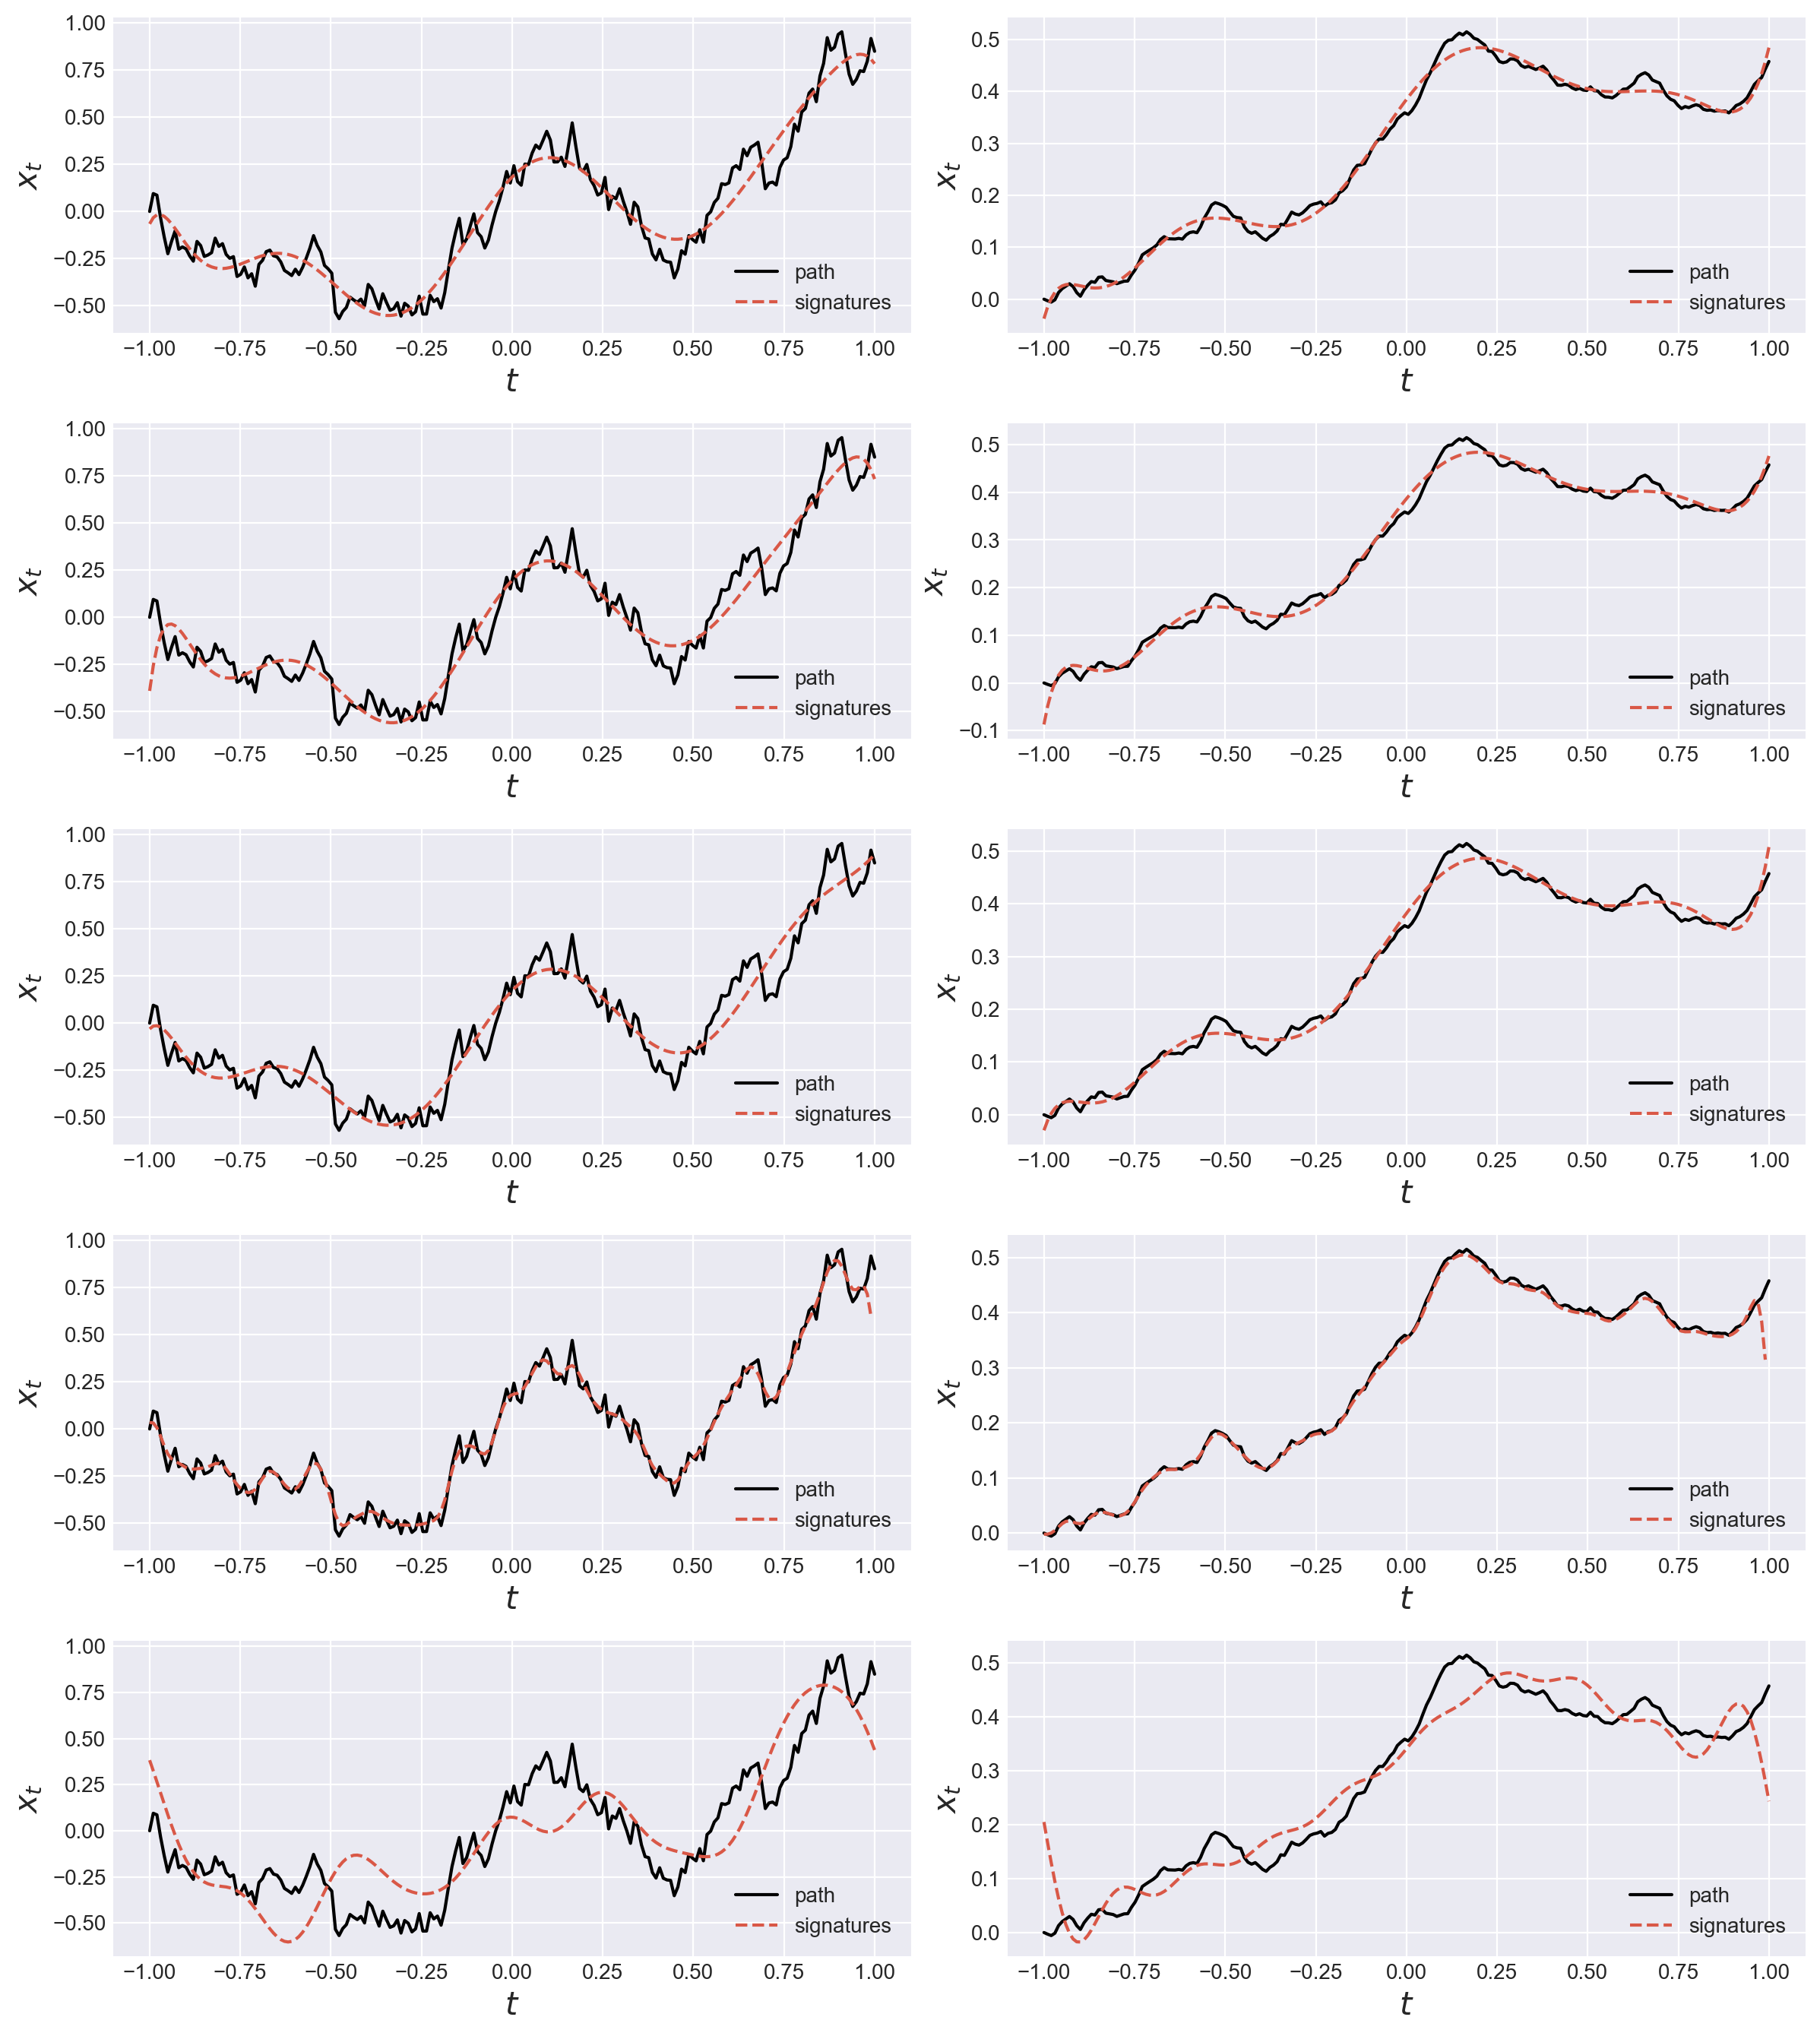

In [32]:
plt.figure(figsize=(12, 13.5), dpi=200)

poly = Legendre()
path_time1 = np.c_[t_grid, x1*poly.weight(t_grid)]
sig1 = signature_of_path_iisignature(path_time1, N+2)
path_time2 = np.c_[t_grid, x2*poly.weight(t_grid)]
sig2 = signature_of_path_iisignature(path_time2, N+2)

plt.subplot(5, 2, 1)
plt.plot(t_grid, x1, color='black', label='path')
plt.plot(t_grid, poly.sig2path(sig1, N, t_grid), label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='lower right')
plt.subplot(5, 2, 2)
plt.plot(t_grid, x2, color='black', label='path')
plt.plot(t_grid, poly.sig2path(sig2, N, t_grid), label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='lower right')

poly = Jacobi(0, 0.5)
path_time1 = np.c_[t_grid, x1*poly.weight(t_grid)]
sig1 = signature_of_path_iisignature(path_time1, N+2)
path_time2 = np.c_[t_grid, x2*poly.weight(t_grid)]
sig2 = signature_of_path_iisignature(path_time2, N+2)

plt.subplot(5, 2, 3)
plt.plot(t_grid, x1, color='black', label='path')
plt.plot(t_grid, poly.sig2path(sig1, N, t_grid), label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='lower right')
plt.subplot(5, 2, 4)
plt.plot(t_grid, x2, color='black', label='path')
plt.plot(t_grid, poly.sig2path(sig2, N, t_grid), label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='lower right')

poly = Jacobi(0.5, 0)
path_time1 = np.c_[t_grid, x1*poly.weight(t_grid)]
sig1 = signature_of_path_iisignature(path_time1, N+2)
path_time2 = np.c_[t_grid, x2*poly.weight(t_grid)]
sig2 = signature_of_path_iisignature(path_time2, N+2)

plt.subplot(5, 2, 5)
plt.plot(t_grid, x1, color='black', label='path')
plt.plot(t_grid, poly.sig2path(sig1, N, t_grid), label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='lower right')
plt.subplot(5, 2, 6)
plt.plot(t_grid, x2, color='black', label='path')
plt.plot(t_grid, poly.sig2path(sig2, N, t_grid), label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='lower right')

plt.subplot(5, 2, 7)
plt.plot(t_grid, x1, color='black', label='path')
plt.plot(t_grid[:-1], point_sig(x1, t_grid, 2, 0.025)[:-1], label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='lower right')
plt.subplot(5, 2, 8)
plt.plot(t_grid, x2, color='black', label='path')
plt.plot(t_grid[:-1], point_sig(x2, t_grid, 2, 0.025)[:-1], label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='lower right')

coef1 = fft_aug(x1, N)
reg_coef1 = reg1.predict(sig_AT(x1.reshape(1, -1), 6, time=np.linspace(-1, 1, 200)))
coef2 = fft_aug(x2, N)
reg_coef2 = reg2.predict(sig_AT(x2.reshape(1, -1), 6, time=np.linspace(-1, 1, 200)))

plt.subplot(5, 2, 9)
plt.plot(t_grid, x1, color='black', label='path')
plt.plot(t_grid, ifft_aug(reg_coef1, n=200, f_depth=N).flatten(), label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='lower right')

plt.subplot(5, 2, 10)
plt.plot(t_grid, x2, color='black', label='path')
plt.plot(t_grid, ifft_aug(reg_coef2, n=200, f_depth=N).flatten(), label='signatures', color=colors[-2], linestyle='--')
plt.xlabel(r'$t$', fontsize=15)
plt.ylabel(r'$x_t$', fontsize=15)
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('visual_sig_inv_rough.pdf')

In [27]:
length = 200
iter_num = 15
d_range = range(1, 14)
t_grid = np.linspace(-1, 1, length)
poly_dict_inv = {'Legendre': {'poly': Legendre(), 'error': np.zeros((2, d_range[-1]-d_range[0]+1)), 'time': np.zeros((2, d_range[-1]-d_range[0]+1))},
             'Jacobi(0, 0.5)': {'poly': Jacobi(0, 0.5), 'error': np.zeros((2, d_range[-1]-d_range[0]+1)), 'time': np.zeros((2, d_range[-1]-d_range[0]+1))},
             'Jacobi(0.5, 0)': {'poly': Jacobi(0.5, 0), 'error': np.zeros((2, d_range[-1]-d_range[0]+1)), 'time': np.zeros((2, d_range[-1]-d_range[0]+1))}}
hermite_dict_inv = {'Hermite $\epsilon=0.05$': {'eps': 0.025, 'error': np.zeros((2, d_range[-1]-d_range[0]+1)), 'time': np.zeros((2, d_range[-1]-d_range[0]+1))}}

for n in tqdm(d_range):
    for i in range(iter_num):
        func2 = fbm_generator(1, length, hurst=0.5)[0]
        func = func2-func2[0]
        for sub_dict in poly_dict_inv.values():
            start = time.time()
            path_time = np.c_[t_grid, func*sub_dict['poly'].weight(t_grid)]
            sig = signature_of_path_iisignature(path_time, n+2)
            sub_dict['error'][0, n-d_range[0]] += np.linalg.norm(sub_dict['poly'].sig2path(sig, n, t_grid) - func)
            end = time.time()
            sub_dict['time'][0, n-d_range[0]] = end - start
        if n<=6:
            start = time.time()
            hermite_dict_inv['Hermite $\epsilon=0.05$']['error'][0, n-d_range[0]] += np.linalg.norm(point_sig(func, t_grid, n, eps=0.025)[:-2] - func[:-2])
            end = time.time()
            hermite_dict_inv['Hermite $\epsilon=0.05$']['time'][0, n-d_range[0]] = end - start
        func2 = fbm_generator(1, length, hurst=0.9)[0]
        func = func2-func2[0]
        for sub_dict in poly_dict_inv.values():
            start = time.time()
            path_time = np.c_[t_grid, func*sub_dict['poly'].weight(t_grid)]
            sig = signature_of_path_iisignature(path_time, n+2)
            sub_dict['error'][1, n-d_range[0]] += np.linalg.norm(sub_dict['poly'].sig2path(sig, n, t_grid) - func)
            end = time.time()
            sub_dict['time'][1, n-d_range[0]] = end - start
        if n<=6:
            start = time.time()
            hermite_dict_inv['Hermite $\epsilon=0.05$']['error'][1, n-d_range[0]] += np.linalg.norm(point_sig(func, t_grid, n, eps=0.025)[:-2] - func[:-2])
            end = time.time()
            hermite_dict_inv['Hermite $\epsilon=0.05$']['time'][1, n-d_range[0]] = end - start

total_dict_inv = {**poly_dict_inv, **hermite_dict_inv}
for name, sub_dict in total_dict_inv.items():
    sub_dict['error'] /= iter_num
    sub_dict['time'] /= iter_num

  0%|          | 0/13 [00:00<?, ?it/s]e:\File_VSCode\M3R\m3r_venv\lib\site-packages\fbm\fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(
100%|██████████| 13/13 [11:08<00:00, 51.46s/it]


C:\Users\Besty\AppData\Local\Temp\ipykernel_56188\1114574755.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')
C:\Users\Besty\AppData\Local\Temp\ipykernel_56188\1114574755.py:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)
C:\Users\Besty\AppData\Local\Temp\ipykernel_56188\1114574755.py:49: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes f

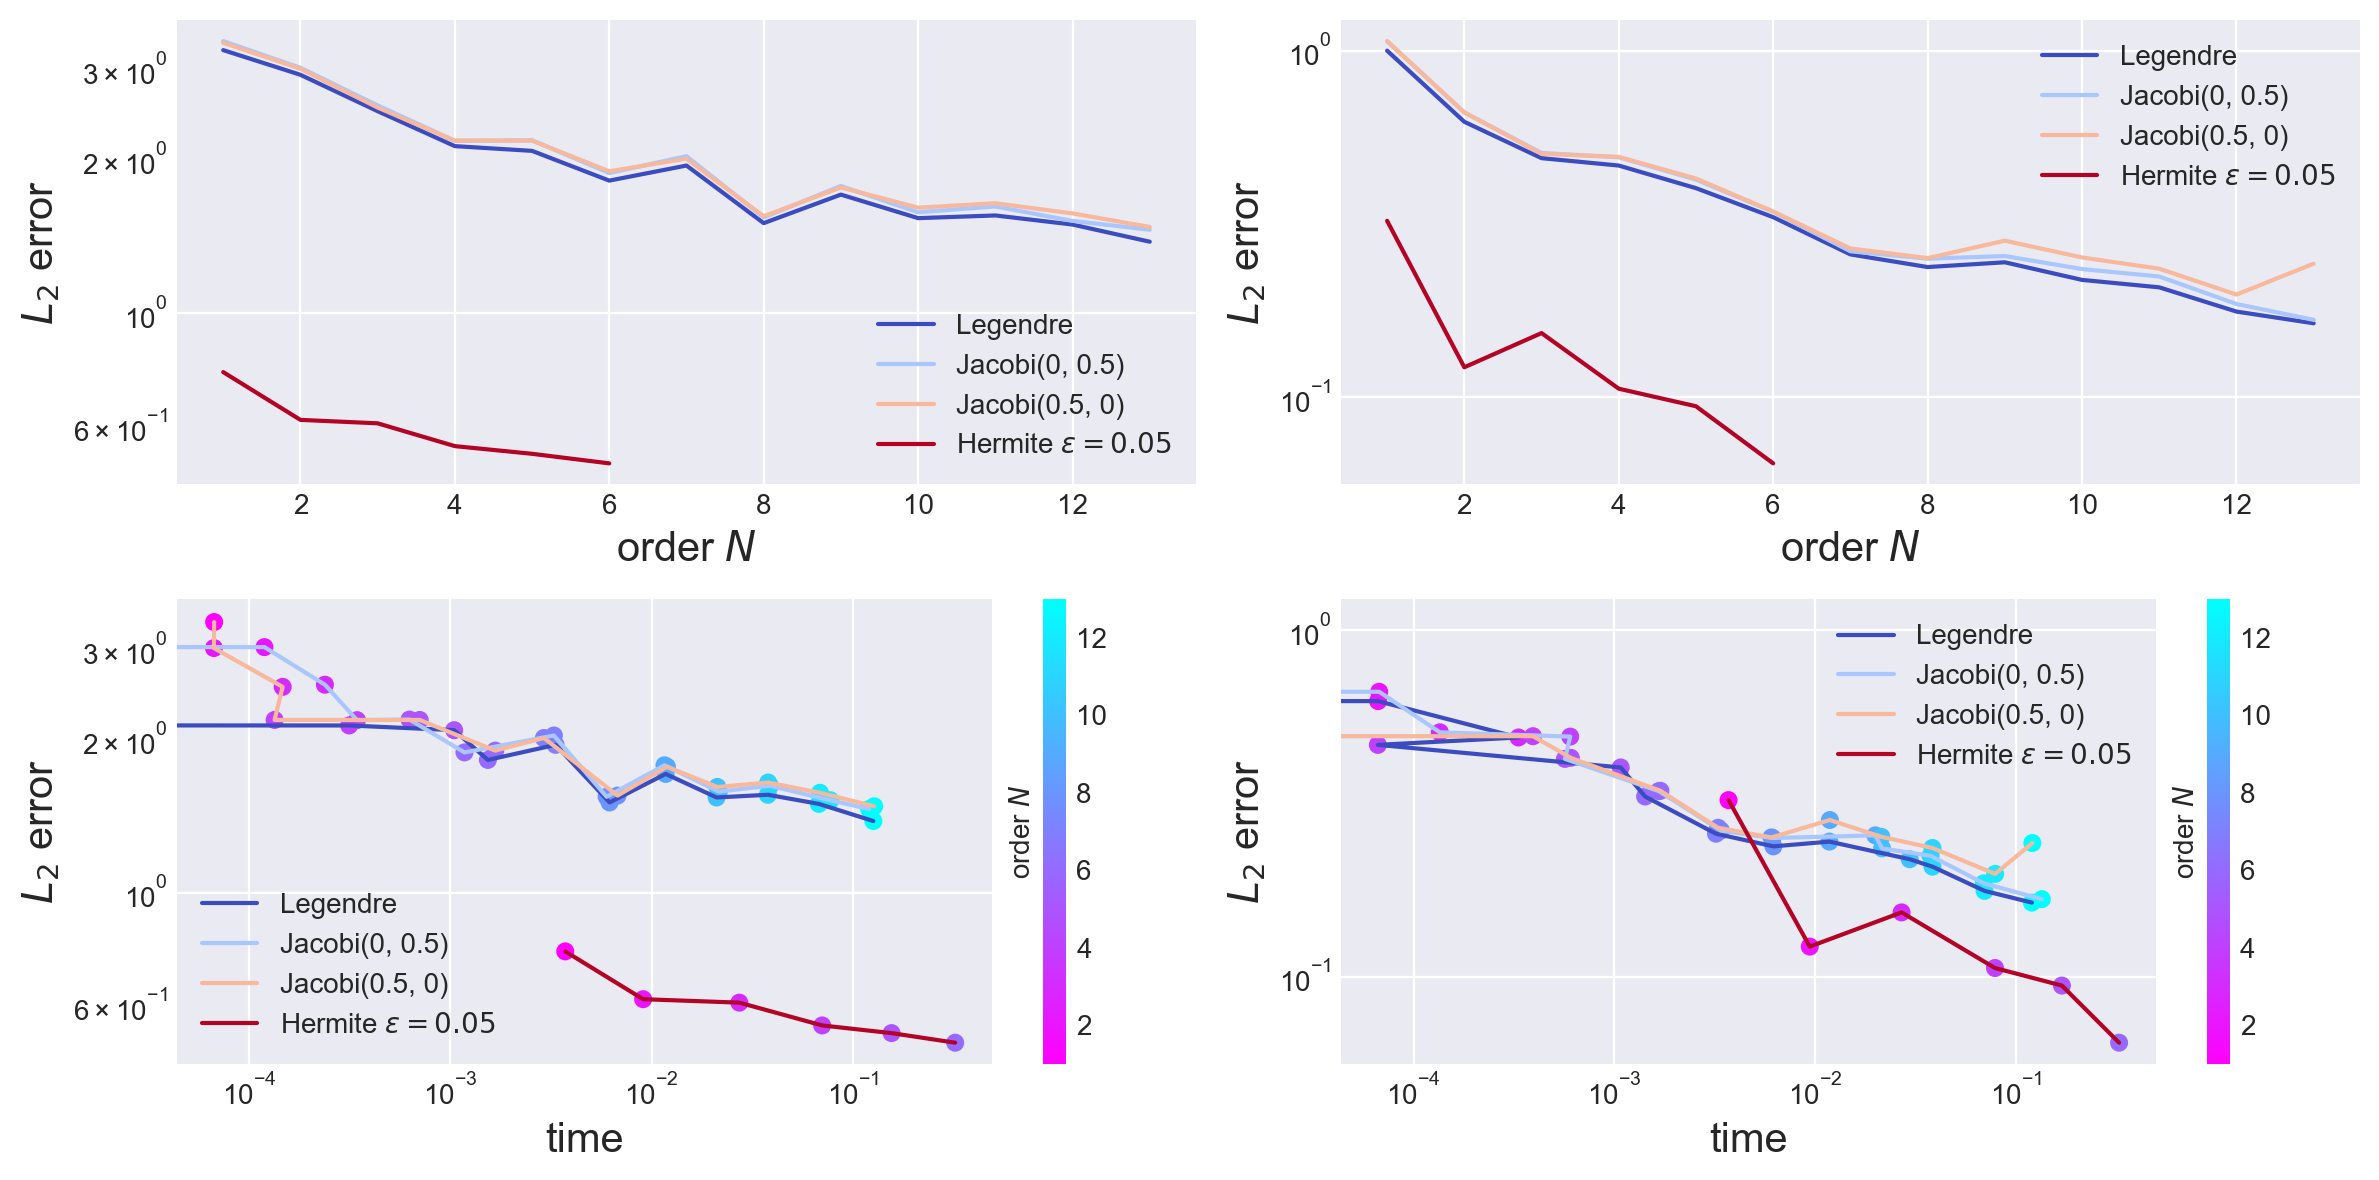

In [30]:
cmap = plt.get_cmap('coolwarm')
c = cmap(np.linspace(0, 1, len(total_dict_inv)))
h = 'Hermite $\epsilon=0.05$'

plt.figure(figsize=(12, 6), dpi=200)
plt.style.use('seaborn-darkgrid')
plt.subplot(2, 2, 1)
for i, (name, sub_dict) in enumerate(poly_dict_inv.items()):
    plt.plot(d_range, sub_dict['error'][0], label=name, color=c[i])
plt.plot(d_range[:6], hermite_dict_inv[h]['error'][0, :6], label=h, color=c[-1])
plt.legend()
plt.yscale('log')
plt.xlabel(r'order $N$', fontsize=15)
plt.ylabel(r'$L_2$ error', fontsize=15)

plt.subplot(2, 2, 2)
for i, (name, sub_dict) in enumerate(poly_dict_inv.items()):
    plt.plot(d_range, sub_dict['error'][1], label=name, color=c[i])
plt.plot(d_range[:6], hermite_dict_inv[h]['error'][1, :6], label=h, color=c[-1])
plt.legend()
plt.yscale('log')
plt.xlabel(r'order $N$', fontsize=15)
plt.ylabel(r'$L_2$ error', fontsize=15)

cmap1 = plt.get_cmap('cool_r')
c1 = cmap1(np.linspace(0, 1, len(d_range)))
plt.subplot(2, 2, 3)
for i, (name, sub_dict) in enumerate(poly_dict_inv.items()):
    plt.plot(sub_dict['time'][0], sub_dict['error'][0], label=name, color=c[i])
    plt.scatter(sub_dict['time'][0], sub_dict['error'][0], color=c1, s=30)
plt.plot(hermite_dict_inv[h]['time'][0, :6], hermite_dict_inv[h]['error'][0, :6], label=h, color=c[-1])
plt.scatter(hermite_dict_inv[h]['time'][0, :6], hermite_dict_inv[h]['error'][0, :6], color=c1[:6], s=30)
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=plt.Normalize(vmin=d_range[0], vmax=d_range[-1]))
cbar = plt.colorbar(sm)
cbar.set_label(r'order $N$', rotation=90, labelpad=-35)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'time', fontsize=15)
plt.ylabel(r'$L_2$ error', fontsize=15)

plt.subplot(2, 2, 4)
for i, (name, sub_dict) in enumerate(poly_dict_inv.items()):
    plt.plot(sub_dict['time'][1], sub_dict['error'][1], label=name, color=c[i])
    plt.scatter(sub_dict['time'][1], sub_dict['error'][1], color=c1, s=30)
plt.plot(hermite_dict_inv[h]['time'][1, :6], hermite_dict_inv[h]['error'][1, :6], label=h, color=c[-1])
plt.scatter(hermite_dict_inv[h]['time'][1, :6], hermite_dict_inv[h]['error'][1, :6], color=c1[:6], s=30)
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=plt.Normalize(vmin=d_range[0], vmax=d_range[-1]))
cbar = plt.colorbar(sm)
cbar.set_label(r'order $N$', rotation=90, labelpad=-35)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'time', fontsize=15)
plt.ylabel(r'$L_2$ error', fontsize=15)

plt.tight_layout()
plt.savefig('inv_error_rough.pdf')

e:\File_VSCode\M3R\m3r_venv\lib\site-packages\fbm\fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(


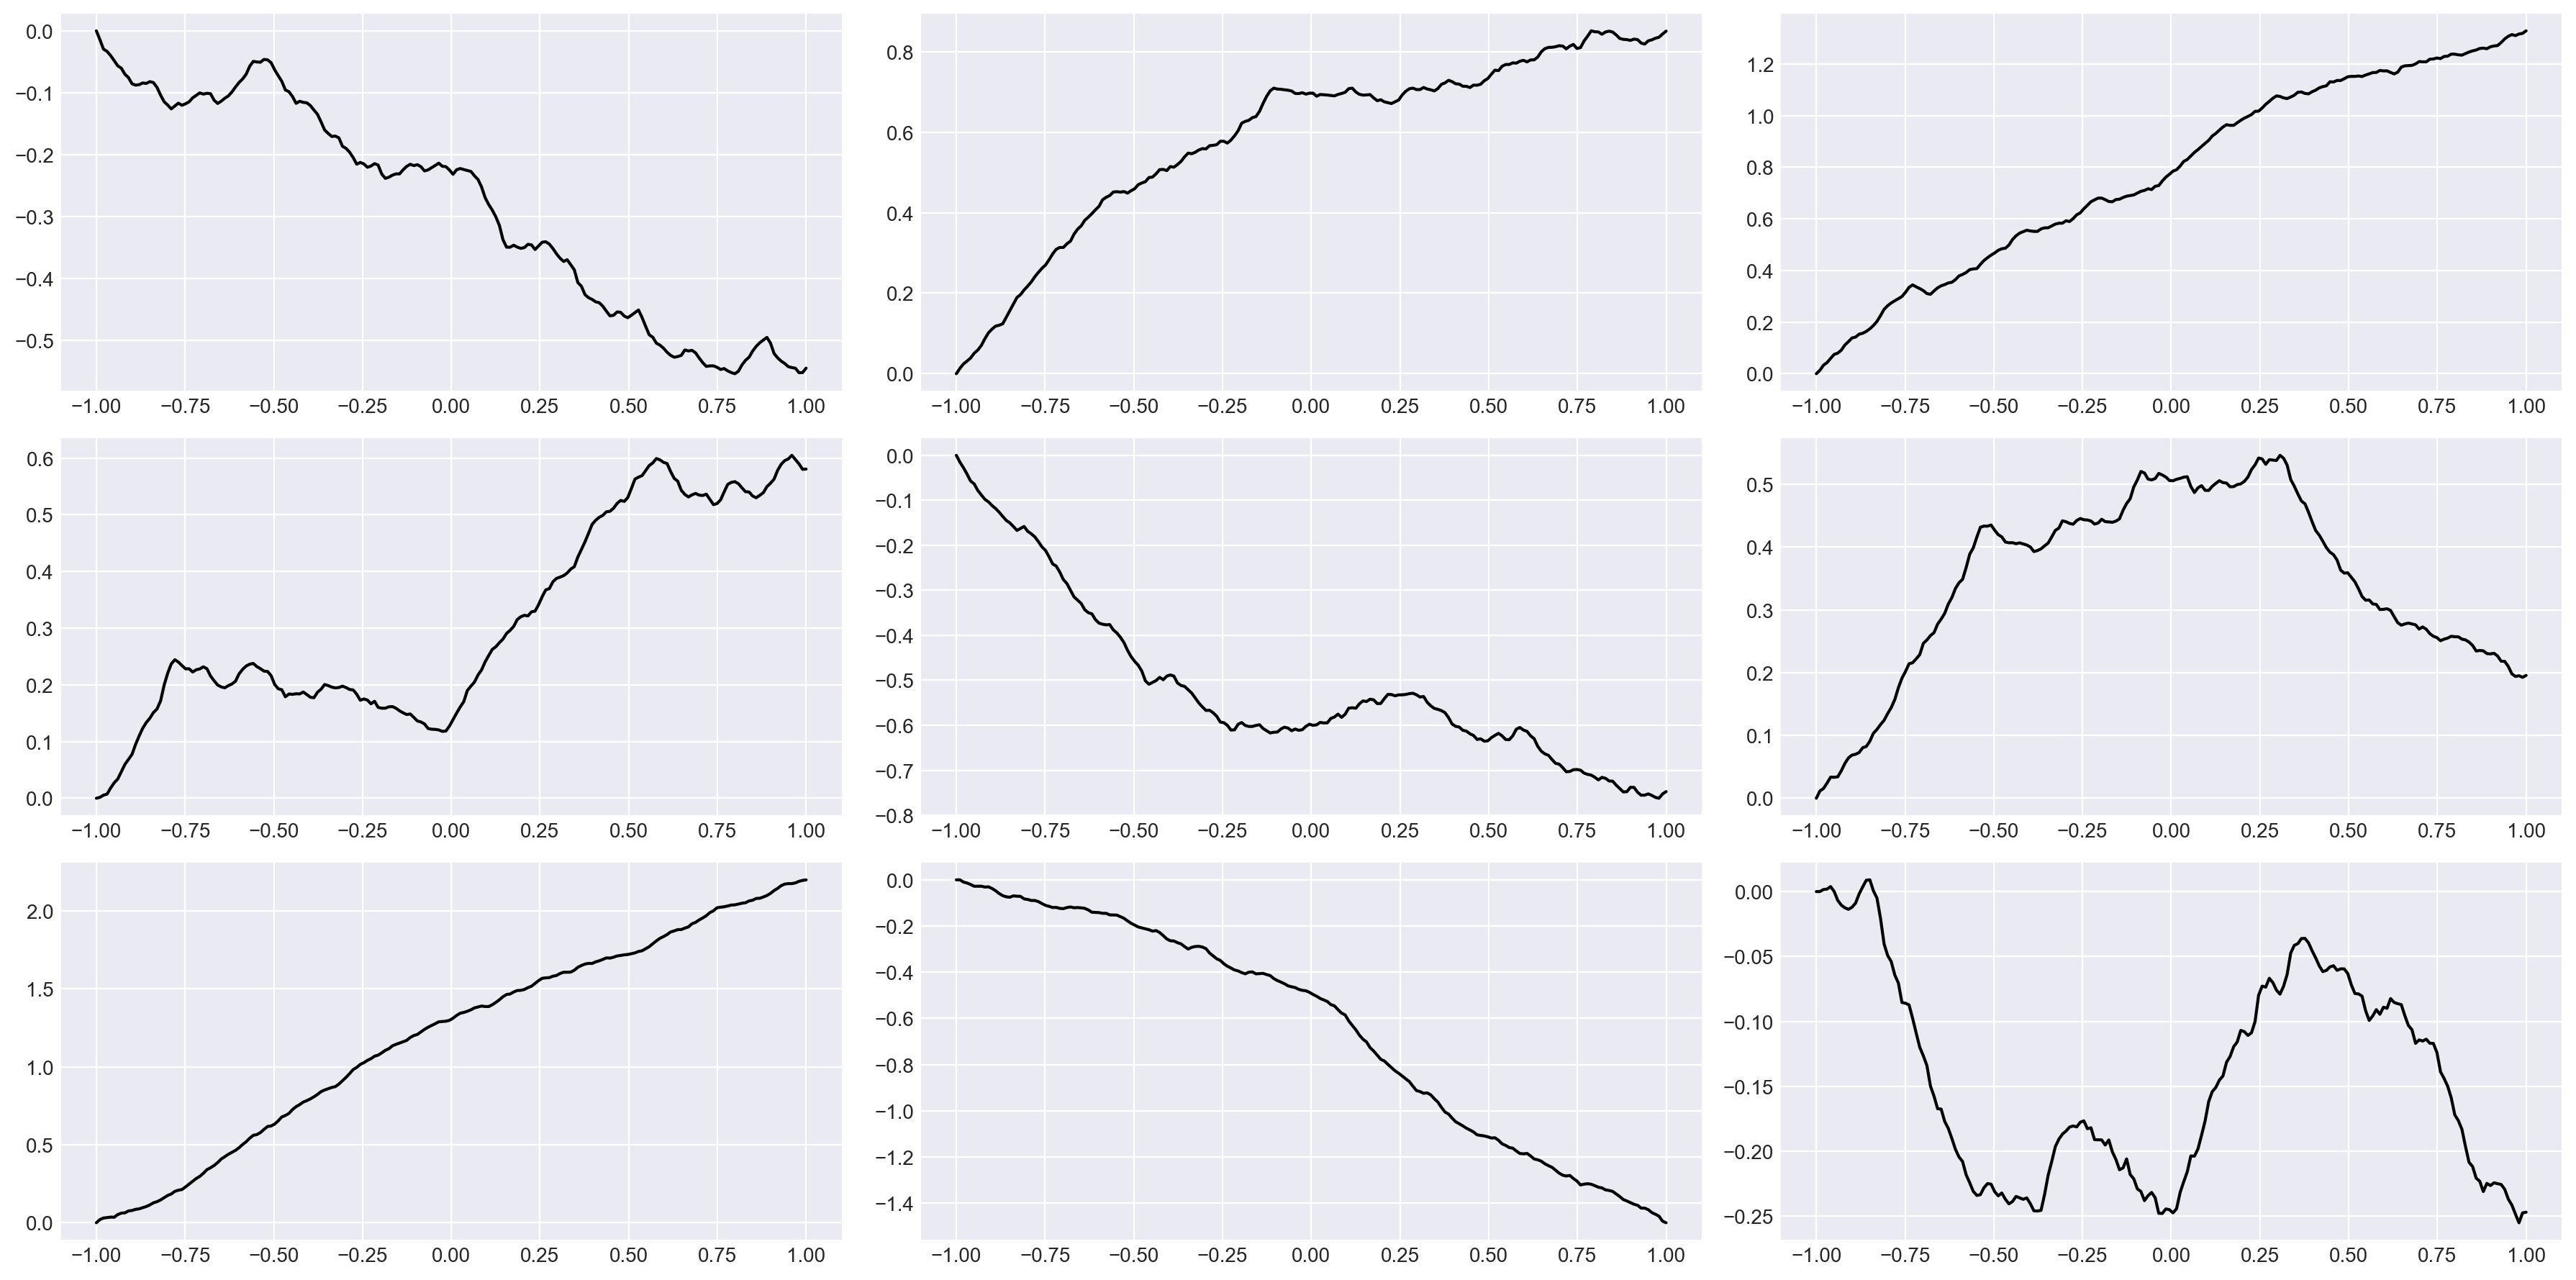

In [35]:
t_grid = np.linspace(-1, 1, 200)

plt.figure(figsize=(18, 9), dpi=200)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.plot(t_grid, fbm_generator(1, 200, hurst=0.9)[0], color='black')
plt.tight_layout()
# plt.savefig('samples_fbm9.pdf')